This notebook was developed by Tiffany Eulalio, modified by Minh Nguyen

# Labels

This notebook generates labels for the data up to 2020.

We will generate the following labels:
1. `admit_label`: level of care at time of admit
2. `recent_24hr_label`: most recent level of care prior to 24 hrs after admit
3. `max_24hr_label`: max level of care within 24 hours - already generated in initial cohort
3. `death_24hr_label`: indicates whether an individual died within 24 hours of admit
4. `recent_24hr_death`: 24 hour recent label with death label incorporated
5. `max_24hr_death`: 24 hour max label with death label incorporated
4. `acute_to_icu_label`: label switched from acute to ICU from admit to 24 hr time
5. `icu_to_acute_label`: label switched from ICU to acute from admit to 24 hr time


Labels 1 through 3 reflect the following:
- 1 = critical care
- 0 = not critical care 

Label 4:
- 1 = died within 24 hours
- 0 = did not die within 24 hours

Label 5 and 6:
- 1 if 24hr or death label is 1
- 0 otherwise

Labels 4 through 5 reflect:
- 1 = switched care level
- 0 = did not switch care level

# Import Packages and Data

- Import Python packages
- Set display settings for Pandas
- Initialize useful functions

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os.path
from os import path
import math

In [2]:
# setting display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# -- more display settings - use this to hide private data
forrepo = 0 # change this to 0 if you want to see hidden columns displayed

hidecols = []
if forrepo:
    hidecols=['anon_id', 'pat_enc_csn_id_coded', 'inpatient_data_id_coded'] # these are hidden columns

## Useful Functions

In [3]:
# use this to describe the tables
def describe_df(df):
    print("df shape", df.shape)
    print("unique CSNs: ", df.pat_enc_csn_id_coded.nunique())
    print("unique patients: ", df.anon_id.nunique())

# Download Data

Only run this if the data is not downloaded locally yet

Download the Cohort table and ADT table.

## Cohort Table

## ADT Table

(We need to pull the `ADT` data for this new cohort. I already ran a SQL call directly on BQ to form the cohort.

Saved the file as `cohort_1_3_adt.csv`
 
Pull the `ADT` data for this new cohort. SQL code below:

# Load locally saved data

Load Cohort table and ADT table. Join them.

In [4]:
# folder with downloaded data locally
datadir = "../../DataTD"
cohortdir = "../../OutputTD/1_cohort"
outdir = "../../OutputTD/1_cohort"

## Cohort Table

In [5]:
cohort = pd.read_csv("{}/1_3_cohort.csv".format(cohortdir))

# cohort.drop('Unnamed: 0', axis=1, inplace=True)

print(cohort.shape) # (45796, 16)
cohort.drop(hidecols, axis=1, errors='ignore').head()

(44258, 10)


,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,DBP,Pulse,RR,SBP,Temp
0,JCd97296,131176042095,18290644,2016-02-06 22:31:00 UTC,0,78,80,14,138,30.0
1,JCcdc7e1,131064611420,13865299,2015-01-15 21:16:00 UTC,1,120,124,14,138,30.0
2,JCe3e5f4,131072326078,14296997,2015-01-28 11:12:00 UTC,1,90,50,15,145,31.0
3,JCdcfce9,131178712824,18633398,2016-03-04 17:01:00 UTC,1,83,71,26,117,32.0
4,JCdaaaa6,131211945620,22773101,2016-12-07 22:17:00 UTC,0,60,51,16,112,34.0


### Note on admit time - no longer true

(The `admit_time` column contains the adjusted/earliest time between `admit_time_jittered` from the `ADT` table and the admission ordered time form the `order_proc` table. This is the time that we will use for the admission time.)

We are not going to use this admit time. Instead, we use the earliest admit time based on the `effective_time_jittered_utc` column in the `ADT` table. We'll grab the admit time from original init cohort0 for consistency, same as in `cohort_enc_code_age`

Looks like the admit time was already updated in this table. We can just use the original time.

## ADT Table

In [6]:
# load the ADT Table
adt = pd.read_csv("{}/cohort_1_3_adt.csv".format(datadir))

describe_df(adt)

adt.drop(hidecols, axis=1, errors='ignore').head()

/home/eulalio/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


df shape (856542, 10)
unique CSNs:  44258
unique patients:  30615


,anon_id,pat_enc_csn_id_coded,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service
0,JCcd7ba7,131277369526,2019-10-31 10:46:00 UTC,4,Inpatient,1.0,66.0,Neonatal ICU - VC Only,Patient Update,Emergency Medicine
1,JCdc0a60,131281229519,2020-01-17 22:12:00 UTC,3,Inpatient,1.0,68.0,Newborn Nursery - VC Only,Patient Update,Emergency Medicine
2,JC2a0efc1,131280575648,2019-12-06 07:22:00 UTC,6,Inpatient,1.0,68.0,Newborn Nursery - VC Only,Patient Update,Emergency
3,JCdc5d49,131240161198,2017-10-08 06:59:00 UTC,2,Emergency Services,NaN,NaN,NaN,Census,Emergency
4,JCe56297,131079845274,2015-04-02 06:59:00 UTC,2,Emergency Services,NaN,NaN,NaN,Census,Emergency


## Join Cohort and ADT

In [7]:
# join the adt to the cohort to make sure we have the correct cohort
joined_cohort_adt = cohort.merge(adt, on=['anon_id', 'pat_enc_csn_id_coded'],
                       how='left')

describe_df(joined_cohort_adt)

joined_cohort_adt.drop(hidecols, axis=1, errors='ignore').head()

df shape (856542, 18)
unique CSNs:  44258
unique patients:  30615


,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,DBP,Pulse,RR,SBP,Temp,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service
0,JCd97296,131176042095,18290644,2016-02-06 22:31:00 UTC,0,78,80,14,138,30.0,2016-02-07 02:56:00 UTC,8,Inpatient,NaN,NaN,NaN,Transfer In,Critical Care
1,JCd97296,131176042095,18290644,2016-02-06 22:31:00 UTC,0,78,80,14,138,30.0,2016-02-07 20:27:00 UTC,10,Inpatient,NaN,NaN,NaN,Transfer Out,Critical Care
2,JCd97296,131176042095,18290644,2016-02-06 22:31:00 UTC,0,78,80,14,138,30.0,2016-02-07 02:54:00 UTC,5,Inpatient,NaN,NaN,NaN,Transfer Out,Critical Care
3,JCd97296,131176042095,18290644,2016-02-06 22:31:00 UTC,0,78,80,14,138,30.0,2016-02-06 22:31:00 UTC,4,Inpatient,1.0,NaN,NaN,Patient Update,Critical Care
4,JCd97296,131176042095,18290644,2016-02-06 22:31:00 UTC,0,78,80,14,138,30.0,2016-02-06 22:15:00 UTC,2,Emergency Services,NaN,NaN,NaN,Transfer Out,NaN


In [8]:
# check that the join didn't mess anything up -- looks good, didn't lost any CSNs or anon_ids
print("cohort: ", cohort.shape, "adt: ", adt.shape, "joined_demo_adt: ", joined_cohort_adt.shape)

print("\nNumber of unique CSNs:")
print("cohort:", cohort.pat_enc_csn_id_coded.nunique(),
     "adt:", adt.pat_enc_csn_id_coded.nunique(),
     "joined:", joined_cohort_adt.pat_enc_csn_id_coded.nunique())

print("\nNumber of unique anon_ids:")
print("cohort:", cohort.anon_id.nunique(),
     "adt:", adt.anon_id.nunique(),
     "joined:", joined_cohort_adt.anon_id.nunique())

cohort:  (44258, 10) adt:  (856542, 10) joined_demo_adt:  (856542, 18)

Number of unique CSNs:
cohort: 44258 adt: 44258 joined: 44258

Number of unique anon_ids:
cohort: 30615 adt: 30615 joined: 30615


In [9]:
# we don't need all of the columns, so keep only the necessary ones for this notebook
keep_cols = ['anon_id', 'pat_enc_csn_id_coded', 'label', 'admit_time',
             'effective_time_jittered_utc', 'seq_num_in_enc', 'pat_class',
             'pat_lv_of_care', 'pat_service', 'event_type']

keep_cohort_adt = joined_cohort_adt[keep_cols]

keep_cohort_adt.drop(hidecols, axis=1, errors='ignore').head()

,anon_id,pat_enc_csn_id_coded,label,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,pat_lv_of_care,pat_service,event_type
0,JCd97296,131176042095,0,2016-02-06 22:31:00 UTC,2016-02-07 02:56:00 UTC,8,Inpatient,NaN,Critical Care,Transfer In
1,JCd97296,131176042095,0,2016-02-06 22:31:00 UTC,2016-02-07 20:27:00 UTC,10,Inpatient,NaN,Critical Care,Transfer Out
2,JCd97296,131176042095,0,2016-02-06 22:31:00 UTC,2016-02-07 02:54:00 UTC,5,Inpatient,NaN,Critical Care,Transfer Out
3,JCd97296,131176042095,0,2016-02-06 22:31:00 UTC,2016-02-06 22:31:00 UTC,4,Inpatient,NaN,Critical Care,Patient Update
4,JCd97296,131176042095,0,2016-02-06 22:31:00 UTC,2016-02-06 22:15:00 UTC,2,Emergency Services,NaN,NaN,Transfer Out


# Data Preprocessing and Quality Control

We need to change the times into datetime format so we can work with them to create the labels. Also, create a column that tells us how long it's been since admit time for each event in the `ADT` table.

## Convert times to datetime

In [10]:
# change the admit time to datetime
keep_cohort_adt.admit_time = pd.to_datetime(keep_cohort_adt.admit_time)

# change the effective time to datetime
keep_cohort_adt['effective_time_jittered_utc'] = pd.to_datetime(keep_cohort_adt.effective_time_jittered_utc)

keep_cohort_adt[['admit_time','effective_time_jittered_utc']].head()

/home/eulalio/.local/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-10-aacb641b100e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keep_cohort_adt['effective_time_jittered_utc'] = pd.to_datetime(keep_cohort_adt.effective_time_jittered_utc)


,admit_time,effective_time_jittered_utc
0,2016-02-06 22:31:00+00:00,2016-02-07 02:56:00+00:00
1,2016-02-06 22:31:00+00:00,2016-02-07 20:27:00+00:00
2,2016-02-06 22:31:00+00:00,2016-02-07 02:54:00+00:00
3,2016-02-06 22:31:00+00:00,2016-02-06 22:31:00+00:00
4,2016-02-06 22:31:00+00:00,2016-02-06 22:15:00+00:00


In [11]:
# compute time since event - this step take a little while
keep_cohort_adt['effective_time_since_admit'] = keep_cohort_adt.apply(lambda x: x.effective_time_jittered_utc - x.admit_time, axis=1)

<ipython-input-11-418dbc8362b4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keep_cohort_adt['effective_time_since_admit'] = keep_cohort_adt.apply(lambda x: x.effective_time_jittered_utc - x.admit_time, axis=1)


In [12]:
key = "effective_time_since_admit"

# check out time since admit - some people have events prior to their admit_time label
print(keep_cohort_adt[key].describe(), "\n")

# look at all of the ADT events for these CSNs that occur prior to admission
prior_to_admit = keep_cohort_adt[keep_cohort_adt[key] < timedelta(hours=0)]

# number of ADT events that occur before admission
print("Number of ADT events that occur before admission: ", prior_to_admit.shape[0], "\n")

# this tells us where people were before admission
print("Pat class prior to admission: \n", prior_to_admit.pat_class.value_counts())

# how many csns have events prior to admit? 45,787
print(prior_to_admit.pat_enc_csn_id_coded.nunique())

prior_to_admit.drop(hidecols, axis=1, errors='ignore').head()

count                        856542
mean      4 days 05:18:26.463781110
std      10 days 00:56:21.917795986
min               -8 days +01:34:00
25%                 0 days 01:08:00
50%                 0 days 21:54:00
75%                 4 days 03:53:00
max               232 days 03:20:00
Name: effective_time_since_admit, dtype: object 

Number of ADT events that occur before admission:  122576 

Pat class prior to admission: 
 Emergency Services    122574
Observation                2
Name: pat_class, dtype: int64
44258


,anon_id,pat_enc_csn_id_coded,label,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,pat_lv_of_care,pat_service,event_type,effective_time_since_admit
4,JCd97296,131176042095,0,2016-02-06 22:31:00+00:00,2016-02-06 22:15:00+00:00,2,Emergency Services,NaN,NaN,Transfer Out,-1 days +23:44:00
10,JCd97296,131176042095,0,2016-02-06 22:31:00+00:00,2016-02-06 19:34:00+00:00,1,Emergency Services,NaN,NaN,Admission,-1 days +21:03:00
11,JCd97296,131176042095,0,2016-02-06 22:31:00+00:00,2016-02-06 22:15:00+00:00,3,Emergency Services,NaN,Emergency,Transfer In,-1 days +23:44:00
25,JCcdc7e1,131064611420,1,2015-01-15 21:16:00+00:00,2015-01-15 12:24:00+00:00,1,Emergency Services,NaN,NaN,Admission,-1 days +15:08:00
26,JCcdc7e1,131064611420,1,2015-01-15 21:16:00+00:00,2015-01-15 12:25:00+00:00,2,Emergency Services,NaN,NaN,Transfer Out,-1 days +15:09:00


## Some patients have many CSNs in the cohort

Most patients only have one CSN in the `demo` table, but there are some with many CSNs. The max number of CSNs for one individual is 41. 

In [13]:
counts = keep_cohort_adt.groupby('anon_id')['pat_enc_csn_id_coded'].nunique().sort_values(ascending=False)

# distribution of CSNs per patient
print(counts.describe())

# number of patients with more than one CSN
print("\nPatients with multiple CSNs: ", sum(counts > 1))

counts.head(10)

count    30615.000000
mean         1.445631
std          1.269613
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         41.000000
Name: pat_enc_csn_id_coded, dtype: float64

Patients with multiple CSNs:  7077


anon_id
JCe8f38d     41
JCdc9c9c     37
JC2a0d68b    35
JCdd32fa     35
JC29fe299    34
JCcfe0cb     31
JCe228ac     28
JCdef5fd     26
JCd96890     24
JCe93616     23
Name: pat_enc_csn_id_coded, dtype: int64

# Admit Level of Care Label

We need to get the first admission event.

In [14]:
# try filtering for exact admit events
admit_events = keep_cohort_adt[keep_cohort_adt.admit_time == keep_cohort_adt.effective_time_jittered_utc] 

# filter for inpatient to get rid of multiple events occuring at admit time
admit_events = admit_events[admit_events.pat_class == "Inpatient"]

print("keep_cohort_adt")
describe_df(keep_cohort_adt)
print("\nadmit events")
describe_df(admit_events) # we don't lose any CSNs so that's good

keep_cohort_adt
df shape (856542, 11)
unique CSNs:  44258
unique patients:  30615

admit events
df shape (44390, 11)
unique CSNs:  44258
unique patients:  30615


## Admit label issues

Some CSNs have no pat lv of care label at admit time.

In [15]:
# count the number of unique labels at admit time
care_counts = admit_events.groupby(['pat_enc_csn_id_coded']).pat_lv_of_care.nunique()
print("\n Number of admit events with distinct lv of care per CSN")
print(care_counts.describe())


 Number of admit events with distinct lv of care per CSN
count    44258.000000
mean         0.977722
std          0.147589
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: pat_lv_of_care, dtype: float64


In [16]:
# looks like some CSNs are missing an admit event label, 
admit_issues = care_counts[care_counts != 1].reset_index()

print("*** Number of CSNs missing admit lv of care:", admit_issues.shape[0])

admit_issues.sort_values('pat_lv_of_care').drop(hidecols, axis=1, errors='ignore')

*** Number of CSNs missing admit lv of care: 986


,pat_enc_csn_id_coded,pat_lv_of_care
0,131063148035,0
649,131184255804,0
650,131184318684,0
651,131184824215,0
652,131184835381,0
...,...,...
334,131133314627,0
335,131163843971,0
336,131163844029,0
338,131163864706,0


### Patients missing lv of care 

There are some patients that are missing the `pat_lv_of_care` entry for the admit event. I looked through several manually and it looks like these individuals tend to be missing the `pat_lv_of_care` for all of their ADT events. This means we can't assign them any labels and so should be removed from the dataset.

In [17]:
# check on these missing admit CSNs
i = 2
missing_csns = admit_issues[admit_issues.pat_lv_of_care == 0]


missing_csns = missing_csns.pat_enc_csn_id_coded.values
print("csns missing admit pat_lv_of_care: ", len(missing_csns))

missing_csn = missing_csns[i]
check = keep_cohort_adt[keep_cohort_adt.pat_enc_csn_id_coded == missing_csn]
check.sort_values(by=['anon_id', 'pat_enc_csn_id_coded', 'effective_time_jittered_utc']).drop(hidecols, axis=1, errors='ignore')

csns missing admit pat_lv_of_care:  986


,anon_id,pat_enc_csn_id_coded,label,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,pat_lv_of_care,pat_service,event_type,effective_time_since_admit
145362,JCde43c3,131063862033,0,2015-01-07 01:02:00+00:00,2015-01-05 22:52:00+00:00,1,Emergency Services,NaN,Emergency,Admission,-2 days +21:50:00
145361,JCde43c3,131063862033,0,2015-01-07 01:02:00+00:00,2015-01-06 03:07:00+00:00,3,Emergency Services,NaN,Emergency,Transfer In,-1 days +02:05:00
145369,JCde43c3,131063862033,0,2015-01-07 01:02:00+00:00,2015-01-06 03:07:00+00:00,2,Emergency Services,NaN,Emergency,Transfer Out,-1 days +02:05:00
145371,JCde43c3,131063862033,0,2015-01-07 01:02:00+00:00,2015-01-06 07:59:00+00:00,4,Emergency Services,NaN,Emergency,Census,-1 days +06:57:00
145367,JCde43c3,131063862033,0,2015-01-07 01:02:00+00:00,2015-01-07 00:56:00+00:00,6,Emergency Services,NaN,Emergency,Transfer In,-1 days +23:54:00
145370,JCde43c3,131063862033,0,2015-01-07 01:02:00+00:00,2015-01-07 00:56:00+00:00,5,Emergency Services,NaN,Emergency,Transfer Out,-1 days +23:54:00
145360,JCde43c3,131063862033,0,2015-01-07 01:02:00+00:00,2015-01-07 01:02:00+00:00,8,Inpatient,NaN,General Medicine (University),Transfer In,0 days 00:00:00
145363,JCde43c3,131063862033,0,2015-01-07 01:02:00+00:00,2015-01-07 01:02:00+00:00,7,Emergency Services,NaN,Emergency,Transfer Out,0 days 00:00:00
145365,JCde43c3,131063862033,0,2015-01-07 01:02:00+00:00,2015-01-07 01:27:00+00:00,10,Inpatient,NaN,General Medicine (University),Transfer In,0 days 00:25:00
145366,JCde43c3,131063862033,0,2015-01-07 01:02:00+00:00,2015-01-07 01:27:00+00:00,9,Inpatient,NaN,General Medicine (University),Transfer Out,0 days 00:25:00


In [18]:
# find patients with NaN only for lv of care
missing_adt = keep_cohort_adt[keep_cohort_adt.pat_enc_csn_id_coded.isin(missing_csns)]

# find those missing admit label, but have lv of care somewhere in adt table
not_all_nan = missing_adt[~missing_adt.pat_lv_of_care.isnull()]

# get csns from these events
not_all_nan_csns = not_all_nan.pat_enc_csn_id_coded.unique()


# find those that have no pav lv of care
fully_missing_csns = [x for x in missing_csns if not x in not_all_nan_csns]

# grab adt table for these
missing_csns_adt = keep_cohort_adt[keep_cohort_adt.pat_enc_csn_id_coded.isin(fully_missing_csns)]
# missing_csns_adt.to_csv("../2019_data/cohort_2019_missing_pat_lv_of_care.csv")

print("Number of CSNS missing pat lv of care across ALL events:", len(fully_missing_csns))

Number of CSNS missing pat lv of care across ALL events: 199


#### Remove CSNs with missing level of care across the entire ADT table.

In [19]:
# filter down the cohort adt table
filtered_cohort_adt = keep_cohort_adt[~keep_cohort_adt.pat_enc_csn_id_coded.isin(fully_missing_csns)]

print("keep_cohort_adt")
describe_df(keep_cohort_adt)
print("\nfiltered_cohort_adt")
describe_df(filtered_cohort_adt) # removed 201 patients


# filter down the cohort table
filtered_cohort = cohort[~cohort.pat_enc_csn_id_coded.isin(fully_missing_csns)]
print("\n\njoined_cohort_adt")
describe_df(joined_cohort_adt)
print("\nfiltered_cohort")
describe_df(filtered_cohort) # removed 202 patients

keep_cohort_adt
df shape (856542, 11)
unique CSNs:  44258
unique patients:  30615

filtered_cohort_adt
df shape (853656, 11)
unique CSNs:  44059
unique patients:  30494


joined_cohort_adt
df shape (856542, 18)
unique CSNs:  44258
unique patients:  30615

filtered_cohort
df shape (44059, 10)
unique CSNs:  44059
unique patients:  30494


## Create labels for patients that have admit events with lv of care

In [20]:
# keep only patients with one lv of care label at admit time
counts = care_counts.reset_index()
keep_csns = counts[counts.pat_lv_of_care == 1].pat_enc_csn_id_coded.values

counts.sort_values('pat_lv_of_care')

keep_admits = admit_events[admit_events.pat_enc_csn_id_coded.isin(keep_csns)]

print("filtered_cohort_adt")
describe_df(filtered_cohort_adt)
print("\nkeep admits")
describe_df(keep_admits) # there are multiple inpatient admit events, but they have the same label so it's okay

print("\nkeep admits + removed csns =", 
      keep_admits.pat_enc_csn_id_coded.nunique() + len(missing_csns)) # we're only missing the ones with no labels

filtered_cohort_adt
df shape (853656, 11)
unique CSNs:  44059
unique patients:  30494

keep admits
df shape (43396, 11)
unique CSNs:  43272
unique patients:  30038

keep admits + removed csns = 44258


In [21]:
# keep only the first admit event for each csn
# all admit events have same label so it's okay to keep - checked these already
unique_admits = keep_admits.groupby("pat_enc_csn_id_coded").first().reset_index()

admit_labels = unique_admits[['pat_enc_csn_id_coded', 'pat_lv_of_care']]
print(admit_labels.pat_lv_of_care.value_counts()) # these NeoNatal ICU and Newborn Nursery might be weird to keep ***

admit_labels['admit_label'] = (admit_labels.pat_lv_of_care == "Critical Care").astype(int)

print("\nCount for admit labels:")
print(admit_labels.admit_label.value_counts())

admit_labels.drop(hidecols, axis=1, errors='ignore')

Acute Care (Assessment or intervention q4-8)                29642
Intermediate Care - With Cardiac Monitor                     6171
Critical Care                                                4758
IICU/Intermediate Care (Assessment or intervention q2-4)     2550
Intermediate Care - No Cardiac Monitor                        148
Newborn Nursery - VC Only                                       2
Neonatal ICU - VC Only                                          1
Name: pat_lv_of_care, dtype: int64

Count for admit labels:
0    38514
1     4758
Name: admit_label, dtype: int64


<ipython-input-21-da0fce178c6f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admit_labels['admit_label'] = (admit_labels.pat_lv_of_care == "Critical Care").astype(int)


,pat_enc_csn_id_coded,pat_lv_of_care,admit_label
0,131062667066,Intermediate Care - With Cardiac Monitor,0
1,131062745090,Acute Care (Assessment or intervention q4-8),0
2,131062747648,Intermediate Care - With Cardiac Monitor,0
3,131062788358,Acute Care (Assessment or intervention q4-8),0
4,131063044001,Acute Care (Assessment or intervention q4-8),0
...,...,...,...
43267,131287787282,Acute Care (Assessment or intervention q4-8),0
43268,131287789243,Acute Care (Assessment or intervention q4-8),0
43269,131287806073,Acute Care (Assessment or intervention q4-8),0
43270,131287838760,Acute Care (Assessment or intervention q4-8),0


### Weird admit labels

Decide whether to keep these (NeoNatal ICU and Newborn Nursery) labels or not. - probably keep them

Join labels to cohort

In [22]:
filtered_cohort_labels = filtered_cohort.merge(admit_labels[['pat_enc_csn_id_coded', 'admit_label']], how='left')

# some are mising an admit label because they were NaN at admit time
sum(filtered_cohort_labels.admit_label.isnull())

filtered_cohort_labels.drop(hidecols, axis=1, errors='ignore')

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,DBP,Pulse,RR,SBP,Temp,admit_label
0,JCd97296,131176042095,18290644,2016-02-06 22:31:00 UTC,0,78,80,14,138,30.00,NaN
1,JCcdc7e1,131064611420,13865299,2015-01-15 21:16:00 UTC,1,120,124,14,138,30.00,1.0
2,JCe3e5f4,131072326078,14296997,2015-01-28 11:12:00 UTC,1,90,50,15,145,31.00,1.0
3,JCdcfce9,131178712824,18633398,2016-03-04 17:01:00 UTC,1,83,71,26,117,32.00,1.0
4,JCdaaaa6,131211945620,22773101,2016-12-07 22:17:00 UTC,0,60,51,16,112,34.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...
44054,JCd8ed6d,131166246836,17986649,2016-01-26 00:37:00 UTC,0,83,120,28,188,39.85,NaN
44055,JCe4c8ec,131223679698,23966392,2017-03-13 01:05:00 UTC,1,63,123,23,110,39.85,NaN
44056,JCe171e3,131164768205,17901045,2016-01-10 01:56:00 UTC,0,76,126,18,112,39.85,0.0
44057,JCe3c736,131240586606,26888176,2017-11-23 06:06:00 UTC,0,76,134,28,116,39.85,0.0


# Most Recent Care Labels

Now we'll get the labels for the most recent event prior to X hours, for X=12 and 24.

In [23]:
# get the adt table for events that happen between admit and X hours only
def get_adtX(X):
    # take only events that occur after admit but before the X hours mark
    adt_X = filtered_cohort_adt[(filtered_cohort_adt.effective_time_since_admit >= timedelta(hours=0))
                                 &
                                 (filtered_cohort_adt.effective_time_since_admit <= timedelta(hours=X))
                                &
                                (~filtered_cohort_adt.pat_lv_of_care.isnull())
                                ]

    # check out distribution of times
    print(adt_X.effective_time_since_admit.describe(), "\n")
    
    print("filtered_cohort_adt")
    describe_df(filtered_cohort_adt)
    print("\nadt_X")
    # check if we lost anyone - we're missing some
    describe_df(adt_X)


    print("\nmissing number of csns:")
    filtered_cohort_csns = filtered_cohort_adt.pat_enc_csn_id_coded.unique()
    adt_X_csns = adt_X.pat_enc_csn_id_coded.unique()
    print(len(filtered_cohort_csns) - len(adt_X_csns))
    
    # get these missing csns to manual check
    missing_csns = [x for x in filtered_cohort_csns if x not in adt_X_csns]
    
    return (adt_X, missing_csns)

In [24]:
X=24
adt_X, missing_csns = get_adtX(X=24)

count                       306050
mean     0 days 05:53:08.912857376
std      0 days 06:47:54.735259909
min                0 days 00:00:00
25%                0 days 01:01:00
50%                0 days 02:42:00
75%                0 days 08:56:00
max                1 days 00:00:00
Name: effective_time_since_admit, dtype: object 

filtered_cohort_adt
df shape (853656, 11)
unique CSNs:  44059
unique patients:  30494

adt_X
df shape (306050, 11)
unique CSNs:  43980
unique patients:  30451

missing number of csns:
79


# Missing 24 hour labels

There are individuals missing 24 hr labels. I checked the first three and they seem to be those with NaN values for `pat_lv_of_care` for all events that occur within 24 hours.

In [25]:
i = 0
missing_csn = missing_csns[i]
check = filtered_cohort_adt[filtered_cohort_adt.pat_enc_csn_id_coded == missing_csn]
check.sort_values('effective_time_jittered_utc').drop(hidecols, axis=1, errors='ignore')

,anon_id,pat_enc_csn_id_coded,label,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,pat_lv_of_care,pat_service,event_type,effective_time_since_admit
7097,JCce98e2,131094146837,0,2015-08-11 16:50:00+00:00,2015-08-11 15:14:00+00:00,1,Emergency Services,NaN,Emergency,Admission,-1 days +22:24:00
7095,JCce98e2,131094146837,0,2015-08-11 16:50:00+00:00,2015-08-11 15:38:00+00:00,3,Emergency Services,NaN,Emergency,Transfer In,-1 days +22:48:00
7094,JCce98e2,131094146837,0,2015-08-11 16:50:00+00:00,2015-08-11 15:38:00+00:00,2,Emergency Services,NaN,Emergency,Transfer Out,-1 days +22:48:00
7087,JCce98e2,131094146837,0,2015-08-11 16:50:00+00:00,2015-08-11 16:50:00+00:00,5,Inpatient,NaN,Cardiology,Transfer In,0 days 00:00:00
7096,JCce98e2,131094146837,0,2015-08-11 16:50:00+00:00,2015-08-11 16:50:00+00:00,4,Emergency Services,NaN,Emergency,Transfer Out,0 days 00:00:00
7088,JCce98e2,131094146837,0,2015-08-11 16:50:00+00:00,2015-08-12 06:59:00+00:00,6,Inpatient,NaN,Cardiology,Census,0 days 14:09:00
7089,JCce98e2,131094146837,0,2015-08-11 16:50:00+00:00,2015-08-13 06:59:00+00:00,7,Inpatient,NaN,Cardiology,Census,1 days 14:09:00
7090,JCce98e2,131094146837,0,2015-08-11 16:50:00+00:00,2015-08-13 23:31:00+00:00,8,Inpatient,NaN,Cardiology,Patient Update,2 days 06:41:00
7086,JCce98e2,131094146837,0,2015-08-11 16:50:00+00:00,2015-08-14 06:59:00+00:00,9,Inpatient,NaN,Cardiology,Census,2 days 14:09:00
7093,JCce98e2,131094146837,0,2015-08-11 16:50:00+00:00,2015-08-15 06:59:00+00:00,10,Inpatient,NaN,Cardiology,Census,3 days 14:09:00


In [40]:
# gets the most recent event before X hours
def get_recent_events(adt_X):
    # sort by the effective time of events
    adt_X.sort_values(by=['anon_id', 'pat_enc_csn_id_coded','effective_time_since_admit', 'seq_num_in_enc'], inplace=True)
    # 'seq_num_in_bed_min' - used to be sorted by this also, but we don't have this col anymore

    describe_df(adt_X)

    # group by CSN and get first event 
    recent_events = adt_X.groupby('pat_enc_csn_id_coded').last().reset_index()

    print(recent_events.effective_time_since_admit.describe())

    return recent_events

recent_events = get_recent_events(adt_X)

# Some patients' most recent event is very early

Minimum is 1 minute after admit. Check this guy out.

In [27]:
recent_events.sort_values(by=['effective_time_since_admit']).head().drop(hidecols, axis=1, errors='ignore')

,pat_enc_csn_id_coded,anon_id,label,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,pat_lv_of_care,pat_service,event_type,effective_time_since_admit
32730,131263388404,JC2a1f517,0,2019-01-17 04:13:00+00:00,2019-01-17 04:13:00+00:00,2,Inpatient,Acute Care (Assessment or intervention q4-8),Oncology,Patient Update,0 days
43331,131284193762,JCe15fbe,0,2020-03-31 07:00:00+00:00,2020-03-31 07:00:00+00:00,15,Inpatient,Acute Care (Assessment or intervention q4-8),General Surgery,Census,0 days
43766,131286440241,JC2a31c61,0,2020-03-31 07:00:00+00:00,2020-03-31 07:00:00+00:00,7,Inpatient,Acute Care (Assessment or intervention q4-8),Trauma,Discharge,0 days
14265,131206976540,JCe33243,0,2016-12-10 21:22:00+00:00,2016-12-10 21:22:00+00:00,7,Inpatient,Acute Care (Assessment or intervention q4-8),Psychiatry,Patient Update,0 days
43574,131284835907,JC29fdded,0,2020-03-31 07:00:00+00:00,2020-03-31 07:00:00+00:00,9,Inpatient,Acute Care (Assessment or intervention q4-8),Medicine,Census,0 days


In [28]:
# this checks out, so at least nothing wrong with code
check = filtered_cohort_adt[filtered_cohort_adt.pat_enc_csn_id_coded == 131263388404]
check.sort_values('effective_time_since_admit').drop(hidecols, axis=1, errors='ignore')

,anon_id,pat_enc_csn_id_coded,label,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,pat_lv_of_care,pat_service,event_type,effective_time_since_admit
607338,JC2a1f517,131263388404,0,2019-01-17 04:13:00+00:00,2019-01-16 23:09:00+00:00,1,Emergency Services,NaN,Emergency,Admission,-1 days +18:56:00
607340,JC2a1f517,131263388404,0,2019-01-17 04:13:00+00:00,2019-01-17 04:13:00+00:00,2,Inpatient,Acute Care (Assessment or intervention q4-8),Oncology,Patient Update,0 days 00:00:00
607337,JC2a1f517,131263388404,0,2019-01-17 04:13:00+00:00,2019-01-17 04:14:00+00:00,3,Observation,NaN,Emergency,Patient Update,0 days 00:01:00
607339,JC2a1f517,131263388404,0,2019-01-17 04:13:00+00:00,2019-01-17 06:44:00+00:00,4,Observation,NaN,Emergency,Discharge,0 days 02:31:00


In [28]:
# we have one row for each event now - each row is the last entry for each event prior to 24 hr mark
print(recent_events.pat_enc_csn_id_coded.nunique())
print(recent_events.shape)

describe_df(recent_events)

recent_events.effective_time_since_admit.describe()

43980
(43980, 11)
df shape (43980, 11)
unique CSNs:  43980
unique patients:  30451


count                        43980
mean     0 days 13:38:54.908594815
std      0 days 07:12:19.125357197
min                0 days 00:00:00
25%                0 days 07:14:00
50%                0 days 13:52:00
75%                0 days 20:38:00
max                1 days 00:00:00
Name: effective_time_since_admit, dtype: object

## Continue with labels again

In [29]:
# look at the level of care assignments across all individuals
print(recent_events.pat_lv_of_care.value_counts())

sum(recent_events.pat_lv_of_care.isnull()) # these are NaN lv of care prior to 24 hr

Acute Care (Assessment or intervention q4-8)                30273
Intermediate Care - With Cardiac Monitor                     6395
Critical Care                                                4156
IICU/Intermediate Care (Assessment or intervention q2-4)     2972
Intermediate Care - No Cardiac Monitor                        184
Name: pat_lv_of_care, dtype: int64


0

In [30]:
label_name = "label_{}hr_recent".format(X)
recent_events[label_name] = (recent_events.pat_lv_of_care == 'Critical Care').astype(int)
recent_events.head().drop(hidecols, axis=1, errors='ignore')

,pat_enc_csn_id_coded,anon_id,label,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,pat_lv_of_care,pat_service,event_type,effective_time_since_admit,label_24hr_recent
0,131062667066,JCe78a06,0,2015-01-02 01:01:00+00:00,2015-01-02 07:59:00+00:00,8,Inpatient,Intermediate Care - With Cardiac Monitor,General Medicine (PAMF),Census,0 days 06:58:00,0
1,131062745090,JCd1c19e,0,2015-01-03 05:53:00+00:00,2015-01-04 00:29:00+00:00,11,Inpatient,Acute Care (Assessment or intervention q4-8),Orthopaedic Surgery,Patient Update,0 days 18:36:00,0
2,131062747648,JCd91eb2,0,2015-01-01 08:24:00+00:00,2015-01-02 07:59:00+00:00,11,Inpatient,Intermediate Care - With Cardiac Monitor,Cardiology Transplant,Census,0 days 23:35:00,0
3,131062788358,JCe7cb4d,0,2015-01-01 23:39:00+00:00,2015-01-02 07:59:00+00:00,4,Inpatient,Acute Care (Assessment or intervention q4-8),Psychiatry,Census,0 days 08:20:00,0
4,131063044001,JCe293de,0,2015-01-05 02:23:00+00:00,2015-01-05 22:30:00+00:00,9,Inpatient,Acute Care (Assessment or intervention q4-8),Neurology,Discharge,0 days 20:07:00,0


In [31]:
# grab relevant columns
labels = recent_events[['pat_enc_csn_id_coded', label_name]]

# join to demo table
filtered_cohort_labels2 = filtered_cohort_labels.merge(labels, how='left', on='pat_enc_csn_id_coded')
filtered_cohort_labels2[label_name] = filtered_cohort_labels2[label_name]

filtered_cohort_labels2.head().drop(hidecols, axis=1, errors='ignore')

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,DBP,Pulse,RR,SBP,Temp,admit_label,label_24hr_recent
0,JCd97296,131176042095,18290644,2016-02-06 22:31:00 UTC,0,78,80,14,138,30.0,NaN,0.0
1,JCcdc7e1,131064611420,13865299,2015-01-15 21:16:00 UTC,1,120,124,14,138,30.0,1.0,1.0
2,JCe3e5f4,131072326078,14296997,2015-01-28 11:12:00 UTC,1,90,50,15,145,31.0,1.0,1.0
3,JCdcfce9,131178712824,18633398,2016-03-04 17:01:00 UTC,1,83,71,26,117,32.0,1.0,1.0
4,JCdaaaa6,131211945620,22773101,2016-12-07 22:17:00 UTC,0,60,51,16,112,34.0,0.0,0.0


In [32]:
# rename the max24 hour label
filtered_cohort_labels2.rename({'label': 'label_max24'},
                             axis=1, inplace=True)

In [33]:
# convert all labels to integers
filtered_cohort_labels2.admit_label = filtered_cohort_labels2.admit_label.astype("Int64")
filtered_cohort_labels2['label_24hr_recent'] = filtered_cohort_labels2['label_24hr_recent'].astype("Int64")


filtered_cohort_labels2.drop(hidecols, axis=1, errors='ignore')

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,DBP,Pulse,RR,SBP,Temp,admit_label,label_24hr_recent
0,JCd97296,131176042095,18290644,2016-02-06 22:31:00 UTC,0,78,80,14,138,30.00,<NA>,0
1,JCcdc7e1,131064611420,13865299,2015-01-15 21:16:00 UTC,1,120,124,14,138,30.00,1,1
2,JCe3e5f4,131072326078,14296997,2015-01-28 11:12:00 UTC,1,90,50,15,145,31.00,1,1
3,JCdcfce9,131178712824,18633398,2016-03-04 17:01:00 UTC,1,83,71,26,117,32.00,1,1
4,JCdaaaa6,131211945620,22773101,2016-12-07 22:17:00 UTC,0,60,51,16,112,34.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
44054,JCd8ed6d,131166246836,17986649,2016-01-26 00:37:00 UTC,0,83,120,28,188,39.85,<NA>,0
44055,JCe4c8ec,131223679698,23966392,2017-03-13 01:05:00 UTC,1,63,123,23,110,39.85,<NA>,1
44056,JCe171e3,131164768205,17901045,2016-01-10 01:56:00 UTC,0,76,126,18,112,39.85,0,0
44057,JCe3c736,131240586606,26888176,2017-11-23 06:06:00 UTC,0,76,134,28,116,39.85,0,0


In [34]:
# check the missing label count for all labels
print(sum(filtered_cohort_labels2.admit_label.isnull()))

print(sum(filtered_cohort_labels2['label_24hr_recent'].isnull()))

787
79


In [35]:
# check label distribution
print(filtered_cohort_labels2['admit_label'].value_counts(), "\n")
print(filtered_cohort_labels2['label_24hr_recent'].value_counts(), "\n")

0    38514
1     4758
Name: admit_label, dtype: Int64 

0    39824
1     4156
Name: label_24hr_recent, dtype: Int64 



In [36]:
describe_df(filtered_cohort_labels2)

df shape (44059, 12)
unique CSNs:  44059
unique patients:  30494


In [39]:
filtered_cohort_labels2.head()

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,DBP,Pulse,RR,SBP,Temp,admit_label,label_24hr_recent
0,JCd97296,131176042095,18290644,2016-02-06 22:31:00 UTC,0,78,80,14,138,30.0,<NA>,0
1,JCcdc7e1,131064611420,13865299,2015-01-15 21:16:00 UTC,1,120,124,14,138,30.0,1,1
2,JCe3e5f4,131072326078,14296997,2015-01-28 11:12:00 UTC,1,90,50,15,145,31.0,1,1
3,JCdcfce9,131178712824,18633398,2016-03-04 17:01:00 UTC,1,83,71,26,117,32.0,1,1
4,JCdaaaa6,131211945620,22773101,2016-12-07 22:17:00 UTC,0,60,51,16,112,34.0,0,0


# Get recent label for a range of hours

In [67]:
def get_recent_label(X):
    # get the adt table with events up until hour X
    adt_X, missing_csns = get_adtX(X)

    # grab the last even that occurred before hour X
    recent_events = get_recent_events(adt_X)

    # create column for critical care label
    label_name = "label_{}hr_recent".format(X)
    recent_events[label_name] = (recent_events.pat_lv_of_care == 'Critical Care').astype(int)
#     recent_events.head().drop(hidecols, axis=1, errors='ignore')

    # grab relevant columns
    newcol_name = "{}_time_since_admit".format(label_name)
    labels = recent_events[['pat_enc_csn_id_coded', label_name, 'effective_time_since_admit']]
    labels = labels.rename({"effective_time_since_admit":newcol_name}, axis=1)
    
    return(labels)

    # join to demo table
#     filtered_cohort_labels2 = filtered_cohort_labels.merge(labels, how='left', on='pat_enc_csn_id_coded')
#     filtered_cohort_labels2[label_name] = filtered_cohort_labels2[label_name]

#     filtered_cohort_labels2.head().drop(hidecols, axis=1, errors='ignore')

#     # rename the max24 hour label
#     filtered_cohort_labels2.rename({'label': 'label_max24'},
#                                  axis=1, inplace=True)

#     # convert all labels to integers
#     filtered_cohort_labels2.admit_label = filtered_cohort_labels2.admit_label.astype("Int64")
#     filtered_cohort_labels2['label_24hr_recent'] = filtered_cohort_labels2['label_24hr_recent'].astype("Int64")


#     filtered_cohort_labels2.drop(hidecols, axis=1, errors='ignore')

#     # check the missing label count for all labels
#     print(sum(filtered_cohort_labels2.admit_label.isnull()))

#     print(sum(filtered_cohort_labels2['label_24hr_recent'].isnull()))

#     # check label distribution
#     print(filtered_cohort_labels2['admit_label'].value_counts(), "\n")
#     print(filtered_cohort_labels2['label_24hr_recent'].value_counts(), "\n")

In [68]:
get_recent_label(24)

count                       306050
mean     0 days 05:53:08.912857376
std      0 days 06:47:54.735259909
min                0 days 00:00:00
25%                0 days 01:01:00
50%                0 days 02:42:00
75%                0 days 08:56:00
max                1 days 00:00:00
Name: effective_time_since_admit, dtype: object 

filtered_cohort_adt
df shape (853656, 11)
unique CSNs:  44059
unique patients:  30494

adt_X
df shape (306050, 11)
unique CSNs:  43980
unique patients:  30451

missing number of csns:
79
df shape (306050, 11)
unique CSNs:  43980
unique patients:  30451
count                        43980
mean     0 days 13:38:54.908594815
std      0 days 07:12:19.125357197
min                0 days 00:00:00
25%                0 days 07:14:00
50%                0 days 13:52:00
75%                0 days 20:38:00
max                1 days 00:00:00
Name: effective_time_since_admit, dtype: object


<ipython-input-40-1a59f0bed532>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adt_X.sort_values(by=['anon_id', 'pat_enc_csn_id_coded','effective_time_since_admit', 'seq_num_in_enc'], inplace=True)


,pat_enc_csn_id_coded,label_24hr_recent,label_24hr_recent_time_since_admit
0,131062667066,0,0 days 06:58:00
1,131062745090,0,0 days 18:36:00
2,131062747648,0,0 days 23:35:00
3,131062788358,0,0 days 08:20:00
4,131063044001,0,0 days 20:07:00
...,...,...,...
43975,131287787282,0,0 days 23:07:00
43976,131287789243,0,0 days 22:40:00
43977,131287806073,0,0 days 09:10:00
43978,131287838760,0,0 days 23:53:00


In [78]:
all_labels = filtered_cohort_adt[['pat_enc_csn_id_coded']].drop_duplicates()

# get the recent labels for the range of hours
for X in range(0,25):
    labels = get_recent_label(X)
    labels.head()
    all_labels = all_labels.merge(labels, how='left', on=['pat_enc_csn_id_coded'])

all_labels.head()

count              43537
mean     0 days 00:00:00
std      0 days 00:00:00
min      0 days 00:00:00
25%      0 days 00:00:00
50%      0 days 00:00:00
75%      0 days 00:00:00
max      0 days 00:00:00
Name: effective_time_since_admit, dtype: object 

filtered_cohort_adt
df shape (853656, 11)
unique CSNs:  44059
unique patients:  30494

adt_X
df shape (43537, 11)
unique CSNs:  43272
unique patients:  30038

missing number of csns:
787


<ipython-input-40-1a59f0bed532>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adt_X.sort_values(by=['anon_id', 'pat_enc_csn_id_coded','effective_time_since_admit', 'seq_num_in_enc'], inplace=True)


df shape (43537, 11)
unique CSNs:  43272
unique patients:  30038
count              43272
mean     0 days 00:00:00
std      0 days 00:00:00
min      0 days 00:00:00
25%      0 days 00:00:00
50%      0 days 00:00:00
75%      0 days 00:00:00
max      0 days 00:00:00
Name: effective_time_since_admit, dtype: object
count                        75544
mean     0 days 00:15:38.298210314
std      0 days 00:21:26.401263985
min                0 days 00:00:00
25%                0 days 00:00:00
50%                0 days 00:00:00
75%                0 days 00:36:00
max                0 days 01:00:00
Name: effective_time_since_admit, dtype: object 

filtered_cohort_adt
df shape (853656, 11)
unique CSNs:  44059
unique patients:  30494

adt_X
df shape (75544, 11)
unique CSNs:  43526
unique patients:  30178

missing number of csns:
533
df shape (75544, 11)
unique CSNs:  43526
unique patients:  30178
count                        43526
mean     0 days 00:10:57.015576896
std      0 days 00:19:33.746048712


143
df shape (235959, 11)
unique CSNs:  43916
unique patients:  30415
count                        43916
mean     0 days 04:44:18.100009108
std      0 days 02:54:53.219836008
min                0 days 00:00:00
25%                0 days 02:11:00
50%                0 days 04:34:00
75%                0 days 07:14:00
max                0 days 10:00:00
Name: effective_time_since_admit, dtype: object
count                       241396
mean     0 days 02:43:48.039569835
std      0 days 02:45:22.251062337
min                0 days 00:00:00
25%                0 days 00:42:00
50%                0 days 01:49:00
75%                0 days 03:59:00
max                0 days 11:00:00
Name: effective_time_since_admit, dtype: object 

filtered_cohort_adt
df shape (853656, 11)
unique CSNs:  44059
unique patients:  30494

adt_X
df shape (241396, 11)
unique CSNs:  43922
unique patients:  30420

missing number of csns:
137
df shape (241396, 11)
unique CSNs:  43922
unique patients:  30420
count             

df shape (279757, 11)
unique CSNs:  43957
unique patients:  30443
count                        43957
mean     0 days 09:24:21.453238392
std      0 days 05:29:23.106084490
min                0 days 00:00:00
25%                0 days 04:49:00
50%                0 days 08:59:00
75%                0 days 14:07:00
max                0 days 19:00:00
Name: effective_time_since_admit, dtype: object
count                       284854
mean     0 days 04:41:02.943191950
std      0 days 05:21:29.509730691
min                0 days 00:00:00
25%                0 days 00:56:00
50%                0 days 02:22:00
75%                0 days 06:46:00
max                0 days 20:00:00
Name: effective_time_since_admit, dtype: object 

filtered_cohort_adt
df shape (853656, 11)
unique CSNs:  44059
unique patients:  30494

adt_X
df shape (284854, 11)
unique CSNs:  43962
unique patients:  30444

missing number of csns:
97
df shape (284854, 11)
unique CSNs:  43962
unique patients:  30444
count                  

,pat_enc_csn_id_coded,label_0hr_recent,label_0hr_recent_time_since_admit,label_1hr_recent,label_1hr_recent_time_since_admit,label_2hr_recent,label_2hr_recent_time_since_admit,label_3hr_recent,label_3hr_recent_time_since_admit,label_4hr_recent,label_4hr_recent_time_since_admit,label_5hr_recent,label_5hr_recent_time_since_admit,label_6hr_recent,label_6hr_recent_time_since_admit,label_7hr_recent,label_7hr_recent_time_since_admit,label_8hr_recent,label_8hr_recent_time_since_admit,label_9hr_recent,label_9hr_recent_time_since_admit,label_10hr_recent,label_10hr_recent_time_since_admit,label_11hr_recent,label_11hr_recent_time_since_admit,label_12hr_recent,label_12hr_recent_time_since_admit,label_13hr_recent,label_13hr_recent_time_since_admit,label_14hr_recent,label_14hr_recent_time_since_admit,label_15hr_recent,label_15hr_recent_time_since_admit,label_16hr_recent,label_16hr_recent_time_since_admit,label_17hr_recent,label_17hr_recent_time_since_admit,label_18hr_recent,label_18hr_recent_time_since_admit,label_19hr_recent,label_19hr_recent_time_since_admit,label_20hr_recent,label_20hr_recent_time_since_admit,label_21hr_recent,label_21hr_recent_time_since_admit,label_22hr_recent,label_22hr_recent_time_since_admit,label_23hr_recent,label_23hr_recent_time_since_admit,label_24hr_recent,label_24hr_recent_time_since_admit
0,131176042095,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0.0,0 days 22:05:00,0.0,0 days 22:05:00
1,131064611420,1.0,0 days,1.0,0 days,1.0,0 days,1.0,0 days,1.0,0 days 00:00:00,1.0,0 days 00:00:00,1.0,0 days 00:00:00,1.0,0 days 00:00:00,1.0,0 days 00:00:00,1.0,0 days 00:00:00,1.0,0 days 00:00:00,1.0,0 days 10:43:00,1.0,0 days 10:43:00,1.0,0 days 10:43:00,1.0,0 days 10:43:00,1.0,0 days 10:43:00,1.0,0 days 10:43:00,1.0,0 days 10:43:00,1.0,0 days 10:43:00,1.0,0 days 10:43:00,1.0,0 days 10:43:00,1.0,0 days 10:43:00,1.0,0 days 10:43:00,1.0,0 days 10:43:00,1.0,0 days 10:43:00
2,131072326078,1.0,0 days,1.0,0 days,1.0,0 days,1.0,0 days,1.0,0 days 00:00:00,1.0,0 days 00:00:00,1.0,0 days 05:24:00,1.0,0 days 05:24:00,1.0,0 days 07:08:00,1.0,0 days 07:08:00,1.0,0 days 07:08:00,1.0,0 days 07:08:00,1.0,0 days 07:08:00,1.0,0 days 07:08:00,1.0,0 days 07:08:00,1.0,0 days 14:50:00,1.0,0 days 14:50:00,1.0,0 days 14:50:00,1.0,0 days 14:50:00,1.0,0 days 14:50:00,1.0,0 days 14:50:00,1.0,0 days 20:47:00,1.0,0 days 20:47:00,1.0,0 days 20:47:00,1.0,0 days 20:47:00
3,131178712824,1.0,0 days,1.0,0 days,1.0,0 days,1.0,0 days,1.0,0 days 03:58:00,1.0,0 days 03:58:00,1.0,0 days 03:58:00,1.0,0 days 03:58:00,1.0,0 days 03:58:00,1.0,0 days 03:58:00,1.0,0 days 03:58:00,1.0,0 days 03:58:00,1.0,0 days 03:58:00,1.0,0 days 03:58:00,1.0,0 days 03:58:00,1.0,0 days 14:58:00,1.0,0 days 14:58:00,1.0,0 days 14:58:00,1.0,0 days 14:58:00,1.0,0 days 14:58:00,1.0,0 days 14:58:00,1.0,0 days 14:58:00,1.0,0 days 14:58:00,1.0,0 days 14:58:00,1.0,0 days 14:58:00
4,131211945620,0.0,0 days,0.0,0 days,0.0,0 days,0.0,0 days,0.0,0 days 00:00:00,0.0,0 days 00:00:00,0.0,0 days 05:18:00,0.0,0 days 05:18:00,0.0,0 days 05:18:00,0.0,0 days 05:18:00,0.0,0 days 09:42:00,0.0,0 days 09:42:00,0.0,0 days 09:42:00,0.0,0 days 09:42:00,0.0,0 days 09:42:00,0.0,0 days 09:42:00,0.0,0 days 09:42:00,0.0,0 days 09:42:00,0.0,0 days 09:42:00,0.0,0 days 09:42:00,0.0,0 days 09:42:00,0.0,0 days 09:42:00,0.0,0 days 09:42:00,0.0,0 days 09:42:00,0.0,0 days 09:42:00


In [79]:
all_labels

,pat_enc_csn_id_coded,label_0hr_recent,label_0hr_recent_time_since_admit,label_1hr_recent,label_1hr_recent_time_since_admit,label_2hr_recent,label_2hr_recent_time_since_admit,label_3hr_recent,label_3hr_recent_time_since_admit,label_4hr_recent,label_4hr_recent_time_since_admit,label_5hr_recent,label_5hr_recent_time_since_admit,label_6hr_recent,label_6hr_recent_time_since_admit,label_7hr_recent,label_7hr_recent_time_since_admit,label_8hr_recent,label_8hr_recent_time_since_admit,label_9hr_recent,label_9hr_recent_time_since_admit,label_10hr_recent,label_10hr_recent_time_since_admit,label_11hr_recent,label_11hr_recent_time_since_admit,label_12hr_recent,label_12hr_recent_time_since_admit,label_13hr_recent,label_13hr_recent_time_since_admit,label_14hr_recent,label_14hr_recent_time_since_admit,label_15hr_recent,label_15hr_recent_time_since_admit,label_16hr_recent,label_16hr_recent_time_since_admit,label_17hr_recent,label_17hr_recent_time_since_admit,label_18hr_recent,label_18hr_recent_time_since_admit,label_19hr_recent,label_19hr_recent_time_since_admit,label_20hr_recent,label_20hr_recent_time_since_admit,label_21hr_recent,label_21hr_recent_time_since_admit,label_22hr_recent,label_22hr_recent_time_since_admit,label_23hr_recent,label_23hr_recent_time_since_admit,label_24hr_recent,label_24hr_recent_time_since_admit
0,131176042095,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0.0,0 days 22:05:00,0.0,0 days 22:05:00
1,131064611420,1.0,0 days,1.0,0 days 00:00:00,1.0,0 days 00:00:00,1.0,0 days 00:00:00,1.0,0 days 00:00:00,1.0,0 days 00:00:00,1.0,0 days 00:00:00,1.0,0 days 00:00:00,1.0,0 days 00:00:00,1.0,0 days 00:00:00,1.0,0 days 00:00:00,1.0,0 days 10:43:00,1.0,0 days 10:43:00,1.0,0 days 10:43:00,1.0,0 days 10:43:00,1.0,0 days 10:43:00,1.0,0 days 10:43:00,1.0,0 days 10:43:00,1.0,0 days 10:43:00,1.0,0 days 10:43:00,1.0,0 days 10:43:00,1.0,0 days 10:43:00,1.0,0 days 10:43:00,1.0,0 days 10:43:00,1.0,0 days 10:43:00
2,131072326078,1.0,0 days,1.0,0 days 00:00:00,1.0,0 days 00:00:00,1.0,0 days 00:00:00,1.0,0 days 00:00:00,1.0,0 days 00:00:00,1.0,0 days 05:24:00,1.0,0 days 05:24:00,1.0,0 days 07:08:00,1.0,0 days 07:08:00,1.0,0 days 07:08:00,1.0,0 days 07:08:00,1.0,0 days 07:08:00,1.0,0 days 07:08:00,1.0,0 days 07:08:00,1.0,0 days 14:50:00,1.0,0 days 14:50:00,1.0,0 days 14:50:00,1.0,0 days 14:50:00,1.0,0 days 14:50:00,1.0,0 days 14:50:00,1.0,0 days 20:47:00,1.0,0 days 20:47:00,1.0,0 days 20:47:00,1.0,0 days 20:47:00
3,131178712824,1.0,0 days,1.0,0 days 00:00:00,1.0,0 days 00:00:00,1.0,0 days 00:00:00,1.0,0 days 03:58:00,1.0,0 days 03:58:00,1.0,0 days 03:58:00,1.0,0 days 03:58:00,1.0,0 days 03:58:00,1.0,0 days 03:58:00,1.0,0 days 03:58:00,1.0,0 days 03:58:00,1.0,0 days 03:58:00,1.0,0 days 03:58:00,1.0,0 days 03:58:00,1.0,0 days 14:58:00,1.0,0 days 14:58:00,1.0,0 days 14:58:00,1.0,0 days 14:58:00,1.0,0 days 14:58:00,1.0,0 days 14:58:00,1.0,0 days 14:58:00,1.0,0 days 14:58:00,1.0,0 days 14:58:00,1.0,0 days 14:58:00
4,131211945620,0.0,0 days,0.0,0 days 00:00:00,0.0,0 days 00:00:00,0.0,0 days 00:00:00,0.0,0 days 00:00:00,0.0,0 days 00:00:00,0.0,0 days 05:18:00,0.0,0 days 05:18:00,0.0,0 days 05:18:00,0.0,0 days 05:18:00,0.0,0 days 09:42:00,0.0,0 days 09:42:00,0.0,0 days 09:42:00,0.0,0 days 09:42:00,0.0,0 days 09:42:00,0.0,0 days 09:42:00,0.0,0 days 09:42:00,0.0,0 days 09:42:00,0.0,0 days 09:42:00,0.0,0 days 09:42:00,0.0,0 days 09:42:00,0.0,0 days 09:42:00,0.0,0 days 09:42:00,0.0,0 days 09:42:00,0.0,0 days 09:42:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44054,131166246836,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0.0,0 days 05:08:00,0.0,0 days 05:08:00,0.0,0 days 07:22:00,0.0,0 days 07:22:00,0.0,0 days 07:22:00,0.0,0 days 07:22:00,0.0,0 days 07:2

In [80]:
# save this data
savefile = "../../OutputTD/1_cohort/1_4_recent_labels.csv"
all_labels.to_csv(savefile, index=False)

## Deal with individuals with NaN admit lv of care

Some CSNs do not have admit labels, but they do have 24 hour labels. We will 
1. give these people a label based on their earliest level of care and their 24 hour label. 
2. We'll include a flag to indicate that these people didn't have admit labels. 
3. We'll also include the time of their earliest label.

In [38]:
# get flag to indicate whether individuals had an admit label
# switch_labels = filtered_cohort_labels2
filtered_cohort_labels2['has_admit_label'] = (~filtered_cohort_labels2.admit_label.isnull()).astype(int)
print(filtered_cohort_labels2.has_admit_label.value_counts())

filtered_cohort_labels2.head()

# subset to those that do not have admit label
no_admit = filtered_cohort_labels2[filtered_cohort_labels2.has_admit_label == 0]
no_admit.head()
no_admit_csns = no_admit.pat_enc_csn_id_coded.values

print("\nnew cohort:")
print(describe_df(filtered_cohort_labels2))
print("\nno admit")
print(describe_df(no_admit)) # 787 CSNs with no admit time

1    43272
0      787
Name: has_admit_label, dtype: int64

new cohort:
df shape (44059, 13)
unique CSNs:  44059
unique patients:  30494
None

no admit
df shape (787, 13)
unique CSNs:  787
unique patients:  773
None


# Missing all labels

There are some people who are missing labels for admit time, and 24 hr. We can't really do anything with these right now. We'll identify these individuals and remove them from the cohort.

We can also look at the distribution of their first labels.

1    79
Name: admit_label, dtype: int64
count     79.000000
mean      58.496414
std       52.151430
min       24.483333
25%       30.175000
50%       41.566667
75%       63.233333
max      330.900000
Name: effective_time_since_admit, dtype: float64


<AxesSubplot:>

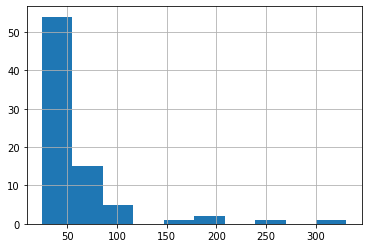

In [39]:
# find csns with no labels across the board
missing_labels = filtered_cohort_labels2[['admit_label', 
                        'label_24hr_recent']].isnull().astype(int)
missing_labels['pat_enc_csn_id_coded'] = filtered_cohort_labels2['pat_enc_csn_id_coded']

no_admit = missing_labels[missing_labels.admit_label == 1] 
no_labels = no_admit[no_admit.label_24hr_recent == 1]

print(no_labels['admit_label'].value_counts()) # 82 people have no labels before 24 hrs

# manuall check some of them - looks good
# new_cohort[new_cohort.pat_enc_csn_id_coded == no_labels.pat_enc_csn_id_coded.values[50]]

no_labels_csns = no_labels.pat_enc_csn_id_coded.values # will probably remove these from cohort

# pull the adt for these CSNs with no admit times
no_labels_adt = filtered_cohort_adt[filtered_cohort_adt.pat_enc_csn_id_coded.isin(no_labels_csns)]

## these individuals must have a label somewhere, find out where

# sort out events with no lv of care
has_lv_of_care = no_labels_adt[~no_labels_adt.pat_lv_of_care.isnull()]
has_lv_of_care = has_lv_of_care[has_lv_of_care.effective_time_since_admit > timedelta(hours=0)]
has_lv_of_care.pat_enc_csn_id_coded.nunique() # we have at least one per csn 

# find first event for each csn
has_lv_of_care.sort_values(by=['pat_enc_csn_id_coded', 'effective_time_jittered_utc'], inplace=True)
first_label = has_lv_of_care.groupby(['pat_enc_csn_id_coded']).first()

sec_since_admit = first_label.effective_time_since_admit.astype('timedelta64[s]')
hour_since_admit = sec_since_admit / 3600 # num of sec in an hour
print(hour_since_admit.describe())
hour_since_admit.hist()

# Continue without these individuals


708
708
count    708.000000
mean       3.498282
std        4.887343
min        0.016667
25%        0.300000
50%        1.775000
75%        4.087500
max       23.516667
Name: effective_time_since_admit, dtype: float64


<AxesSubplot:>

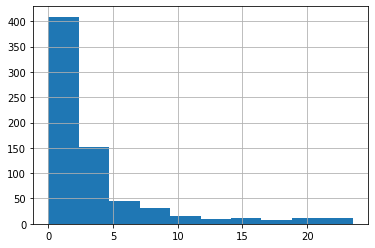

In [40]:
# keep the no_admit cohort but not the no_label cohort
has_some_label = filtered_cohort_labels2[~filtered_cohort_labels2.pat_enc_csn_id_coded.isin(no_labels_csns)] # 708 are left
admit_cohort = has_some_label[has_some_label.pat_enc_csn_id_coded.isin(no_admit_csns)]

## find the earliest level of care 
admit_cohort_csns = admit_cohort.pat_enc_csn_id_coded.values

# pull the adt for these CSNs with no admit times
admit_cohort_adt = filtered_cohort_adt[
    filtered_cohort_adt.pat_enc_csn_id_coded.isin(admit_cohort_csns)]

## these individuals must have a label somewhere, find out where

# sort out events with no lv of care
has_lv_of_care = admit_cohort_adt[~admit_cohort_adt.pat_lv_of_care.isnull()]
print(has_lv_of_care.pat_enc_csn_id_coded.nunique())
has_lv_of_care = has_lv_of_care[has_lv_of_care.effective_time_since_admit > timedelta(hours=0)]
print(has_lv_of_care.pat_enc_csn_id_coded.nunique()) 
has_lv_of_care.pat_enc_csn_id_coded.nunique() # we have at least one per csn 

# find first event for each csn
has_lv_of_care.sort_values(by=['pat_enc_csn_id_coded', 'effective_time_jittered_utc',
                              'seq_num_in_enc'], inplace=True)
first_label = has_lv_of_care.groupby(['pat_enc_csn_id_coded']).first().reset_index()

sec_since_admit = first_label.effective_time_since_admit.astype('timedelta64[s]')
hour_since_admit = sec_since_admit / 3600 # num of sec in an hour
print(hour_since_admit.describe())
hour_since_admit.hist()

In [38]:
# we now have the first event for each CSN
print(first_label.pat_enc_csn_id_coded.nunique()) # 708 - we have everyone, except that one that dropped off
first_label_short = first_label[['pat_enc_csn_id_coded', 'pat_lv_of_care', 'effective_time_since_admit']]

# check out lv of care here
print(first_label_short.pat_lv_of_care.value_counts())

# make sure no null values
print(sum(first_label_short.pat_lv_of_care.isnull())) # 0 = good

# create label
first_label_short['first_label'] = (first_label_short.pat_lv_of_care == 'Critical Care').astype(int)

print(first_label_short.first_label.value_counts()) # makes sense

# rename the time since admit column
first_label_short.rename({'effective_time_since_admit': 'first_label_time_since_admit'}, 
                         axis='columns', inplace=True)

first_label_short.drop(hidecols, axis=1, errors='ignore')

NameError: name 'first_label' is not defined

# Checking into the first label time distribution

In [37]:
first_label_short['first_label_minutes_since_admit'] = first_label_short.first_label_time_since_admit / pd.Timedelta('1 minute')

NameError: name 'first_label_short' is not defined

In [43]:
ordered_first_labels = first_label_short.sort_values('first_label_minutes_since_admit', ascending=False)
ordered_first_labels.drop(hidecols, axis=1, errors='ignore')

,pat_enc_csn_id_coded,pat_lv_of_care,first_label_time_since_admit,first_label,first_label_minutes_since_admit
453,131202414799,Acute Care (Assessment or intervention q4-8),0 days 23:31:00,0,1411.0
48,131087094376,Intermediate Care - With Cardiac Monitor,0 days 23:31:00,0,1411.0
24,131079318361,Acute Care (Assessment or intervention q4-8),0 days 23:23:00,0,1403.0
408,131187762583,Acute Care (Assessment or intervention q4-8),0 days 23:18:00,0,1398.0
308,131176945588,Acute Care (Assessment or intervention q4-8),0 days 23:10:00,0,1390.0
...,...,...,...,...,...
563,131249033455,Acute Care (Assessment or intervention q4-8),0 days 00:01:00,0,1.0
562,131248852215,Acute Care (Assessment or intervention q4-8),0 days 00:01:00,0,1.0
561,131248767726,IICU/Intermediate Care (Assessment or interven...,0 days 00:01:00,0,1.0
559,131248164837,Acute Care (Assessment or intervention q4-8),0 days 00:01:00,0,1.0


In [44]:
i=1
csn = ordered_first_labels.pat_enc_csn_id_coded.values[i]
keep_cohort_adt[keep_cohort_adt.pat_enc_csn_id_coded == csn][['pat_enc_csn_id_coded', 'admit_time',
                                                                 'pat_class', 'pat_lv_of_care',
                                                                 'effective_time_jittered_utc', 
                                                                 'effective_time_since_admit']].sort_values('effective_time_jittered_utc').drop(hidecols, axis=1, errors='ignore')

,pat_enc_csn_id_coded,admit_time,pat_class,pat_lv_of_care,effective_time_jittered_utc,effective_time_since_admit
8321,131087094376,2015-05-15 20:48:00+00:00,Emergency Services,NaN,2015-05-15 12:56:00+00:00,-1 days +16:08:00
8324,131087094376,2015-05-15 20:48:00+00:00,Emergency Services,NaN,2015-05-15 17:36:00+00:00,-1 days +20:48:00
8317,131087094376,2015-05-15 20:48:00+00:00,Emergency Services,NaN,2015-05-15 17:36:00+00:00,-1 days +20:48:00
8318,131087094376,2015-05-15 20:48:00+00:00,Emergency Services,NaN,2015-05-15 17:36:00+00:00,-1 days +20:48:00
8322,131087094376,2015-05-15 20:48:00+00:00,Emergency Services,NaN,2015-05-15 17:36:00+00:00,-1 days +20:48:00
8323,131087094376,2015-05-15 20:48:00+00:00,Emergency Services,NaN,2015-05-15 20:48:00+00:00,0 days 00:00:00
8316,131087094376,2015-05-15 20:48:00+00:00,Inpatient,NaN,2015-05-15 20:48:00+00:00,0 days 00:00:00
8319,131087094376,2015-05-15 20:48:00+00:00,Inpatient,NaN,2015-05-16 06:59:00+00:00,0 days 10:11:00
8329,131087094376,2015-05-15 20:48:00+00:00,Inpatient,Intermediate Care - With Cardiac Monitor,2015-05-16 20:19:00+00:00,0 days 23:31:00
8320,131087094376,2015-05-15 20:48:00+00:00,Inpatient,NaN,2015-05-16 20:19:00+00:00,0 days 23:31:00


array([[<AxesSubplot:title={'center':'first_label_minutes_since_admit'}>]],
      dtype=object)

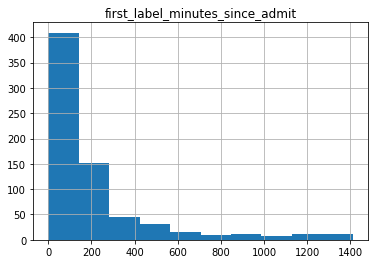

In [45]:
first_label_short.hist('first_label_minutes_since_admit')

In [46]:
# join the first labels to the new cohort
new_cohort_labels = filtered_cohort_labels2.merge(first_label_short[['pat_enc_csn_id_coded', 'first_label', 
                                                                     'first_label_minutes_since_admit']],
                how='left')

In [47]:
new_cohort_labels_full = new_cohort_labels[~new_cohort_labels.pat_enc_csn_id_coded.isin(no_labels_csns)]

print("new cohort labels")
describe_df(new_cohort_labels)
print("\nnew cohort labels full")
describe_df(new_cohort_labels_full) # we lose those 82 csns that had no labels across the board

new cohort labels
df shape (44059, 15)
unique CSNs:  44059
unique patients:  30494

new cohort labels full
df shape (43980, 15)
unique CSNs:  43980
unique patients:  30451


# Death Labels

Checking on the patients that died in our cohort. Specifically looking for any that died within 24 hours of being admitted.

We will change their 24 hour label to 1 if it is not already.

## Format the data

Reading in files that were pulled and saved from BQ.

Query death dates from BQ using the SQL code below.

Saved the results as `cohort_1_3_demo_deaths18.csv` and `cohort_1_3_demo_deaths19.csv`.

Pull the demographics table for our cohort with the death date included. If the death date is NaN, then the individual is considered alive.

The 2018 data was pulled from the initial database, and then 2019 data was pulled from a later release.

We need both of these because if a patient dies prior to 2018, their death date is not correctly listed in the 2019 data.

SQL to pull the 2019 death dates from demographics table:

In [48]:
# read in the file
deaths19 = pd.read_csv("{}/cohort_1_3_demo_deaths19.csv".format(datadir))

In [49]:
# how many anon_ids do we have in the deaths table? 30,451
cohort_deaths = deaths19[deaths19.anon_id.isin(new_cohort_labels_full.anon_id)]
print(cohort_deaths.anon_id.nunique())

# number of unique anon_id and csns in our cohort to begin with
# 30,451 anon_id
# 43,980 csns
print("\nnew cohort labels full")
describe_df(new_cohort_labels_full)

30451

new cohort labels full
df shape (43980, 15)
unique CSNs:  43980
unique patients:  30451


Number of anon_ids matches, so we can move forward.

In [50]:
# get the 2019 deaths
cohort_deaths19 = deaths19[deaths19.anon_id.isin(new_cohort_labels_full.anon_id)]
cohort_deaths19.rename({'ANON_ID':'anon_id',
                       'death_date_jittered':'death_date_2019'},
                      inplace=True, axis=1)
# cohort_deaths19.head()

# join 2018prior and 2019 death dates
all_deaths = cohort_deaths19

/home/eulalio/.local/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [51]:
# check out people who have a death date
died = all_deaths[(~all_deaths.death_date_2019.isnull())]
died

,anon_id,death_date_2019
9,JCcc0c7a,2019-03-06
10,JCda6da3,2019-05-18
12,JCd32d34,2019-01-01
15,JCe7a32b,2019-12-24
19,JCd025df,2019-01-01
...,...,...
30592,JCcf1b8d,2019-01-01
30599,JCe96964,2019-11-14
30604,JCcc39ba,2019-01-01
30610,JCcdb61b,2020-03-31


In [52]:
# join the deaths data to labels
labels_deaths = new_cohort_labels_full.merge(all_deaths, how='left')

# change the dates to datetime
labels_deaths.death_date_2019 = pd.to_datetime(labels_deaths.death_date_2019)

# column indicating whether someone died
labels_deaths['died'] = (~labels_deaths.death_date_2019.isnull())

In [53]:
labels_deaths.drop(hidecols, axis=1, errors='ignore').head()

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,DBP,Pulse,RR,SBP,Temp,admit_label,label_24hr_recent,has_admit_label,first_label,first_label_minutes_since_admit,death_date_2019,died
0,JCd97296,131176042095,18290644,2016-02-06 22:31:00 UTC,0,78,80,14,138,30.0,<NA>,0,0,0.0,1325.0,NaT,False
1,JCcdc7e1,131064611420,13865299,2015-01-15 21:16:00 UTC,1,120,124,14,138,30.0,1,1,1,NaN,NaN,NaT,False
2,JCe3e5f4,131072326078,14296997,2015-01-28 11:12:00 UTC,1,90,50,15,145,31.0,1,1,1,NaN,NaN,NaT,False
3,JCdcfce9,131178712824,18633398,2016-03-04 17:01:00 UTC,1,83,71,26,117,32.0,1,1,1,NaN,NaN,NaT,False
4,JCdaaaa6,131211945620,22773101,2016-12-07 22:17:00 UTC,0,60,51,16,112,34.0,0,0,1,NaN,NaN,NaT,False


In [54]:
labels_deaths['death_date'] = labels_deaths.death_date_2019

In [55]:
# find out how much time has passed since admit time and death
labels_deaths['admit_time'] = pd.to_datetime(labels_deaths.admit_time) 
labels_deaths['death_date'] = pd.to_datetime(labels_deaths.death_date)

# get the date from admit time
labels_deaths['admit_date'] = labels_deaths.admit_time.dt.date
labels_deaths['admit_date'] = pd.to_datetime(labels_deaths.admit_date)

# calculate time between death and admit
labels_deaths['admit_death_delta'] = labels_deaths.death_date - labels_deaths.admit_date

labels_deaths.drop(hidecols, axis=1, errors='ignore').head()

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,DBP,Pulse,RR,SBP,Temp,admit_label,label_24hr_recent,has_admit_label,first_label,first_label_minutes_since_admit,death_date_2019,died,death_date,admit_date,admit_death_delta
0,JCd97296,131176042095,18290644,2016-02-06 22:31:00+00:00,0,78,80,14,138,30.0,<NA>,0,0,0.0,1325.0,NaT,False,NaT,2016-02-06,NaT
1,JCcdc7e1,131064611420,13865299,2015-01-15 21:16:00+00:00,1,120,124,14,138,30.0,1,1,1,NaN,NaN,NaT,False,NaT,2015-01-15,NaT
2,JCe3e5f4,131072326078,14296997,2015-01-28 11:12:00+00:00,1,90,50,15,145,31.0,1,1,1,NaN,NaN,NaT,False,NaT,2015-01-28,NaT
3,JCdcfce9,131178712824,18633398,2016-03-04 17:01:00+00:00,1,83,71,26,117,32.0,1,1,1,NaN,NaN,NaT,False,NaT,2016-03-04,NaT
4,JCdaaaa6,131211945620,22773101,2016-12-07 22:17:00+00:00,0,60,51,16,112,34.0,0,0,1,NaN,NaN,NaT,False,NaT,2016-12-07,NaT


In [56]:
labels_deaths[labels_deaths.pat_enc_csn_id_coded == 131284409583][['anon_id', 'pat_enc_csn_id_coded', 'admit_time',
                                                                  'death_date', 'admit_death_delta']]

,anon_id,pat_enc_csn_id_coded,admit_time,death_date,admit_death_delta
42983,JCdc9538,131284409583,2020-03-30 14:37:00+00:00,2020-03-31,1 days


# Died within 1 day

Find out which individuals died within 24 hours of being admitted.

If an individual was in non-ICU, but died within 24 hours, change their label to 1. Indicate that these individuals were in a critical condition.

I will add a column called `died_within_24hrs` which can be used to change the existing label columns downstream.

In [57]:
days=1
died_1day = labels_deaths[labels_deaths.admit_death_delta <= timedelta(days=days)]

labels_deaths['died_within_24hrs'] = (labels_deaths.admit_death_delta <= timedelta(days=days)).astype(int)

labels_deaths.sort_values('admit_death_delta').drop(hidecols, axis=1, errors='ignore').head()

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,DBP,Pulse,RR,SBP,Temp,admit_label,label_24hr_recent,has_admit_label,first_label,first_label_minutes_since_admit,death_date_2019,died,death_date,admit_date,admit_death_delta,died_within_24hrs
20525,JCe83587,131267837304,36950625,2019-06-08 06:06:00+00:00,0,74,105,18,132,37.90,0,0,1,NaN,NaN,2019-01-01,True,2019-01-01,2019-06-08,-158 days,1
31038,JCe7a32b,131281602422,44967751,2019-12-24 04:00:00+00:00,1,100,136,24,123,36.20,1,0,1,NaN,NaN,2019-12-24,True,2019-12-24,2019-12-24,0 days,1
13521,JCcdd164,131279817519,43896963,2019-12-10 10:15:00+00:00,1,97,86,18,139,36.15,<NA>,1,0,1.0,254.0,2019-12-10,True,2019-12-10,2019-12-10,0 days,1
21028,JC2a2846a,131265178905,35185519,2019-02-21 11:15:00+00:00,1,35,139,18,62,36.05,1,1,1,NaN,NaN,2019-02-21,True,2019-02-21,2019-02-21,0 days,1
12292,JCe6d824,131281045851,44616644,2020-01-09 06:50:00+00:00,0,37,87,18,149,37.75,0,0,1,NaN,NaN,2020-01-09,True,2020-01-09,2020-01-09,0 days,1


In [58]:
labels_deaths.died.value_counts()

False    38109
True      5871
Name: died, dtype: int64

In [59]:
## one individual with negative delta -- may be an entry error? **
# maybe remove this individual later??
# everyone else seems fine
died_1day.admit_death_delta.value_counts()

1 days       10
0 days        9
-158 days     1
Name: admit_death_delta, dtype: int64

In [60]:
# how are these individuals distributed as far as admit label goes?
died_1day.admit_label.value_counts()

0    12
1     7
Name: admit_label, dtype: Int64

In [61]:
# how do the recent 24hr labels look?
died_1day.label_24hr_recent.value_counts()

1    12
0     8
Name: label_24hr_recent, dtype: Int64

In [62]:
labels_deaths.sort_values('admit_death_delta').drop(hidecols, axis=1, errors='ignore')

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,DBP,Pulse,RR,SBP,Temp,admit_label,label_24hr_recent,has_admit_label,first_label,first_label_minutes_since_admit,death_date_2019,died,death_date,admit_date,admit_death_delta,died_within_24hrs
20525,JCe83587,131267837304,36950625,2019-06-08 06:06:00+00:00,0,74,105,18,132,37.90,0,0,1,NaN,NaN,2019-01-01,True,2019-01-01,2019-06-08,-158 days,1
31038,JCe7a32b,131281602422,44967751,2019-12-24 04:00:00+00:00,1,100,136,24,123,36.20,1,0,1,NaN,NaN,2019-12-24,True,2019-12-24,2019-12-24,0 days,1
13521,JCcdd164,131279817519,43896963,2019-12-10 10:15:00+00:00,1,97,86,18,139,36.15,<NA>,1,0,1.0,254.0,2019-12-10,True,2019-12-10,2019-12-10,0 days,1
21028,JC2a2846a,131265178905,35185519,2019-02-21 11:15:00+00:00,1,35,139,18,62,36.05,1,1,1,NaN,NaN,2019-02-21,True,2019-02-21,2019-02-21,0 days,1
12292,JCe6d824,131281045851,44616644,2020-01-09 06:50:00+00:00,0,37,87,18,149,37.75,0,0,1,NaN,NaN,2020-01-09,True,2020-01-09,2020-01-09,0 days,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43974,JCda4e27,131250112012,29824388,2018-03-31 18:48:00+00:00,1,74,118,24,160,39.85,1,1,1,NaN,NaN,NaT,False,NaT,2018-03-31,NaT,0
43975,JCd8ed6d,131166246836,17986649,2016-01-26 00:37:00+00:00,0,83,120,28,188,39.85,<NA>,0,0,0.0,308.0,NaT,False,NaT,2016-01-26,NaT,0
43977,JCe171e3,131164768205,17901045,2016-01-10 01:56:00+00:00,0,76,126,18,112,39.85,0,0,1,NaN,NaN,NaT,False,NaT,2016-01-10,NaT,0
43978,JCe3c736,131240586606,26888176,2017-11-23 06:06:00+00:00,0,76,134,28,116,39.85,0,0,1,NaN,NaN,NaT,False,NaT,2017-11-23,NaT,0


## Incorporate death into max and recent 24 hour labels

These labels will be:

- 1 if either max24_hr_label is 1 or died_within_24hrs is 1
- 0 otherwise

In [63]:
labels_deaths['death_24hr_max_label'] = ((labels_deaths.died_within_24hrs == 1) | (labels_deaths.label_max24 == 1)).astype(int)
labels_deaths['death_24hr_recent_label'] = ((labels_deaths.died_within_24hrs == 1) | (labels_deaths.label_24hr_recent == 1)).astype(int)

In [64]:
labels_deaths.drop(hidecols, axis=1, errors='ignore')

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,DBP,Pulse,RR,SBP,Temp,admit_label,label_24hr_recent,has_admit_label,first_label,first_label_minutes_since_admit,death_date_2019,died,death_date,admit_date,admit_death_delta,died_within_24hrs,death_24hr_max_label,death_24hr_recent_label
0,JCd97296,131176042095,18290644,2016-02-06 22:31:00+00:00,0,78,80,14,138,30.00,<NA>,0,0,0.0,1325.0,NaT,False,NaT,2016-02-06,NaT,0,0,0
1,JCcdc7e1,131064611420,13865299,2015-01-15 21:16:00+00:00,1,120,124,14,138,30.00,1,1,1,NaN,NaN,NaT,False,NaT,2015-01-15,NaT,0,1,1
2,JCe3e5f4,131072326078,14296997,2015-01-28 11:12:00+00:00,1,90,50,15,145,31.00,1,1,1,NaN,NaN,NaT,False,NaT,2015-01-28,NaT,0,1,1
3,JCdcfce9,131178712824,18633398,2016-03-04 17:01:00+00:00,1,83,71,26,117,32.00,1,1,1,NaN,NaN,NaT,False,NaT,2016-03-04,NaT,0,1,1
4,JCdaaaa6,131211945620,22773101,2016-12-07 22:17:00+00:00,0,60,51,16,112,34.00,0,0,1,NaN,NaN,NaT,False,NaT,2016-12-07,NaT,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43975,JCd8ed6d,131166246836,17986649,2016-01-26 00:37:00+00:00,0,83,120,28,188,39.85,<NA>,0,0,0.0,308.0,NaT,False,NaT,2016-01-26,NaT,0,0,0
43976,JCe4c8ec,131223679698,23966392,2017-03-13 01:05:00+00:00,1,63,123,23,110,39.85,<NA>,1,0,0.0,1.0,2019-01-01,True,2019-01-01,2017-03-13,659 days,0,1,1
43977,JCe171e3,131164768205,17901045,2016-01-10 01:56:00+00:00,0,76,126,18,112,39.85,0,0,1,NaN,NaN,NaT,False,NaT,2016-01-10,NaT,0,0,0
43978,JCe3c736,131240586606,26888176,2017-11-23 06:06:00+00:00,0,76,134,28,116,39.85,0,0,1,NaN,NaN,NaT,False,NaT,2017-11-23,NaT,0,0,0


# Create Switch Labels

We're creating labels that indicate whether a CSN switched from acute -> ICU or vice versa between admit time and 24 hours. For CSNs with both labels, this will be easy. 

We will use the 24 hour max and recent labels with death incorporated.

In [65]:
# start by cleaning up the labels dataframe to columns that we care about
keep_columns = ['anon_id', 'pat_enc_csn_id_coded', 'inpatient_data_id_coded',
                'admit_time', 
                'label_max24', 'admit_label', 'label_24hr_recent', 
                'has_admit_label', 'first_label', 'first_label_minutes_since_admit', 
                'died_within_24hrs', 'death_24hr_max_label', 'death_24hr_recent_label']

cleaned_labels = labels_deaths[keep_columns]

cleaned_labels.drop(hidecols, axis=1, errors='ignore')

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,admit_label,label_24hr_recent,has_admit_label,first_label,first_label_minutes_since_admit,died_within_24hrs,death_24hr_max_label,death_24hr_recent_label
0,JCd97296,131176042095,18290644,2016-02-06 22:31:00+00:00,0,<NA>,0,0,0.0,1325.0,0,0,0
1,JCcdc7e1,131064611420,13865299,2015-01-15 21:16:00+00:00,1,1,1,1,NaN,NaN,0,1,1
2,JCe3e5f4,131072326078,14296997,2015-01-28 11:12:00+00:00,1,1,1,1,NaN,NaN,0,1,1
3,JCdcfce9,131178712824,18633398,2016-03-04 17:01:00+00:00,1,1,1,1,NaN,NaN,0,1,1
4,JCdaaaa6,131211945620,22773101,2016-12-07 22:17:00+00:00,0,0,0,1,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43975,JCd8ed6d,131166246836,17986649,2016-01-26 00:37:00+00:00,0,<NA>,0,0,0.0,308.0,0,0,0
43976,JCe4c8ec,131223679698,23966392,2017-03-13 01:05:00+00:00,1,<NA>,1,0,0.0,1.0,0,1,1
43977,JCe171e3,131164768205,17901045,2016-01-10 01:56:00+00:00,0,0,0,1,NaN,NaN,0,0,0
43978,JCe3c736,131240586606,26888176,2017-11-23 06:06:00+00:00,0,0,0,1,NaN,NaN,0,0,0


In [66]:
new_cohort_labels_full = cleaned_labels

In [67]:
# move values from events that have admit labels to first label
def first_label(row):
    if isinstance(row['admit_label'], int):
        return row.admit_label
    else:
        return row.first_label

def first_label_time(row):
    if isinstance(row['admit_label'], int):
        return 0
    else:
        return row.first_label_minutes_since_admit

new_cohort_labels_full['first_label_full'] = new_cohort_labels_full.apply(lambda row: 
                                                                          first_label(row),
                                                                         axis=1)
new_cohort_labels_full['first_label_minutes_since_admit_full'] = new_cohort_labels_full.apply(lambda row: 
                                                                          first_label_time(row),
                                                                         axis=1)

print(new_cohort_labels_full.first_label_full.value_counts())
print(new_cohort_labels_full.first_label.value_counts())
print(sum(new_cohort_labels_full.first_label_full.isnull()))

new_cohort_labels_full.drop(hidecols, axis=1, errors='ignore')

<ipython-input-67-5993b9c5dcb7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_cohort_labels_full['first_label_full'] = new_cohort_labels_full.apply(lambda row:


0.0    39141
1.0     4839
Name: first_label_full, dtype: int64
0.0    627
1.0     81
Name: first_label, dtype: int64
0


<ipython-input-67-5993b9c5dcb7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_cohort_labels_full['first_label_minutes_since_admit_full'] = new_cohort_labels_full.apply(lambda row:


,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,admit_label,label_24hr_recent,has_admit_label,first_label,first_label_minutes_since_admit,died_within_24hrs,death_24hr_max_label,death_24hr_recent_label,first_label_full,first_label_minutes_since_admit_full
0,JCd97296,131176042095,18290644,2016-02-06 22:31:00+00:00,0,<NA>,0,0,0.0,1325.0,0,0,0,0.0,1325.0
1,JCcdc7e1,131064611420,13865299,2015-01-15 21:16:00+00:00,1,1,1,1,NaN,NaN,0,1,1,1.0,0.0
2,JCe3e5f4,131072326078,14296997,2015-01-28 11:12:00+00:00,1,1,1,1,NaN,NaN,0,1,1,1.0,0.0
3,JCdcfce9,131178712824,18633398,2016-03-04 17:01:00+00:00,1,1,1,1,NaN,NaN,0,1,1,1.0,0.0
4,JCdaaaa6,131211945620,22773101,2016-12-07 22:17:00+00:00,0,0,0,1,NaN,NaN,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43975,JCd8ed6d,131166246836,17986649,2016-01-26 00:37:00+00:00,0,<NA>,0,0,0.0,308.0,0,0,0,0.0,308.0
43976,JCe4c8ec,131223679698,23966392,2017-03-13 01:05:00+00:00,1,<NA>,1,0,0.0,1.0,0,1,1,0.0,1.0
43977,JCe171e3,131164768205,17901045,2016-01-10 01:56:00+00:00,0,0,0,1,NaN,NaN,0,0,0,0.0,0.0
43978,JCe3c736,131240586606,26888176,2017-11-23 06:06:00+00:00,0,0,0,1,NaN,NaN,0,0,0,0.0,0.0


In [68]:
# sanity check
check = new_cohort_labels_full
print(sum(check.first_label_full.isnull()))
print(sum(check.first_label_minutes_since_admit_full.isnull()))


check = new_cohort_labels_full[new_cohort_labels_full.admit_label.isnull()]

print(sum(check.first_label_full.isnull()))
print(sum(check.first_label_minutes_since_admit_full.isnull()))

check.drop(hidecols, axis=1, errors='ignore')

0
0
0
0


,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,admit_label,label_24hr_recent,has_admit_label,first_label,first_label_minutes_since_admit,died_within_24hrs,death_24hr_max_label,death_24hr_recent_label,first_label_full,first_label_minutes_since_admit_full
0,JCd97296,131176042095,18290644,2016-02-06 22:31:00+00:00,0,<NA>,0,0,0.0,1325.0,0,0,0,0.0,1325.0
6,JCdb7bb2,131280664882,44427056,2019-11-22 08:10:00+00:00,1,<NA>,1,0,1.0,123.0,0,1,1,1.0,123.0
25,JCe98189,131239698298,26557759,2017-10-04 18:38:00+00:00,0,<NA>,0,0,0.0,1.0,0,0,0,0.0,1.0
41,JCea41d1,131094023871,16004424,2015-07-07 21:31:00+00:00,0,<NA>,0,0,0.0,297.0,0,0,0,0.0,297.0
57,JCe8cbc1,131166314031,17998259,2015-12-28 03:09:00+00:00,1,<NA>,1,0,0.0,216.0,0,1,1,0.0,216.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43640,JCda2b21,131118282136,16718146,2015-09-02 01:35:00+00:00,1,<NA>,1,0,1.0,693.0,0,1,1,1.0,693.0
43790,JCdc9c9c,131264465740,34681499,2019-03-14 08:54:00+00:00,0,<NA>,0,0,0.0,1.0,0,0,0,0.0,1.0
43859,JCd10982,131177569943,18460026,2016-01-14 04:14:00+00:00,0,<NA>,0,0,0.0,88.0,0,0,0,0.0,88.0
43975,JCd8ed6d,131166246836,17986649,2016-01-26 00:37:00+00:00,0,<NA>,0,0,0.0,308.0,0,0,0,0.0,308.0


In [69]:
check = new_cohort_labels_full[~new_cohort_labels_full.admit_label.isnull()]

print(sum(check.first_label_full.isnull()))
print(sum(check.first_label_minutes_since_admit_full.isnull()))

check.drop(hidecols, axis=1, errors='ignore')

0
0


,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,admit_label,label_24hr_recent,has_admit_label,first_label,first_label_minutes_since_admit,died_within_24hrs,death_24hr_max_label,death_24hr_recent_label,first_label_full,first_label_minutes_since_admit_full
1,JCcdc7e1,131064611420,13865299,2015-01-15 21:16:00+00:00,1,1,1,1,NaN,NaN,0,1,1,1.0,0.0
2,JCe3e5f4,131072326078,14296997,2015-01-28 11:12:00+00:00,1,1,1,1,NaN,NaN,0,1,1,1.0,0.0
3,JCdcfce9,131178712824,18633398,2016-03-04 17:01:00+00:00,1,1,1,1,NaN,NaN,0,1,1,1.0,0.0
4,JCdaaaa6,131211945620,22773101,2016-12-07 22:17:00+00:00,0,0,0,1,NaN,NaN,0,0,0,0.0,0.0
5,JCe8840f,131264906504,34995073,2019-02-14 22:22:00+00:00,0,0,0,1,NaN,NaN,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43973,JCeb42c3,131260157177,33116689,2018-11-15 04:25:00+00:00,1,0,1,1,NaN,NaN,0,1,1,0.0,0.0
43974,JCda4e27,131250112012,29824388,2018-03-31 18:48:00+00:00,1,1,1,1,NaN,NaN,0,1,1,1.0,0.0
43977,JCe171e3,131164768205,17901045,2016-01-10 01:56:00+00:00,0,0,0,1,NaN,NaN,0,0,0,0.0,0.0
43978,JCe3c736,131240586606,26888176,2017-11-23 06:06:00+00:00,0,0,0,1,NaN,NaN,0,0,0,0.0,0.0


## Create labels for recent 24 hour label

In [70]:
# new_cohort_labels_full.first_label_full = new_cohort_labels_full.first_label_full

# acute to critical
new_cohort_labels_full['acute_to_critical_label_recent'] = (
    (new_cohort_labels_full.first_label_full == 0) &
    (new_cohort_labels_full.death_24hr_recent_label == 1)).astype(int)

new_cohort_labels_full.acute_to_critical_label_recent.value_counts()

<ipython-input-70-767c6d5905d4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_cohort_labels_full['acute_to_critical_label_recent'] = (


0    43068
1      912
Name: acute_to_critical_label_recent, dtype: int64

In [71]:
# critical to acute
new_cohort_labels_full['critical_to_acute_label_recent'] = (
    (new_cohort_labels_full.first_label_full == 1) &
    (new_cohort_labels_full.death_24hr_recent_label == 0)).astype(int)

new_cohort_labels_full.critical_to_acute_label_recent.value_counts()

<ipython-input-71-41f30c38819b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_cohort_labels_full['critical_to_acute_label_recent'] = (


0    42393
1     1587
Name: critical_to_acute_label_recent, dtype: int64

## Create labels for max 24 hour label

In [72]:
# new_cohort_labels_full.first_label_full = new_cohort_labels_full.first_label_full

# acute to critical
new_cohort_labels_full['acute_to_critical_label_max'] = (
    (new_cohort_labels_full.first_label_full == 0) &
    (new_cohort_labels_full.death_24hr_max_label == 1)).astype(int)

new_cohort_labels_full.acute_to_critical_label_max.value_counts()

<ipython-input-72-64ca8fc08c0b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_cohort_labels_full['acute_to_critical_label_max'] = (


0    42860
1     1120
Name: acute_to_critical_label_max, dtype: int64

In [73]:
# critical to acute
new_cohort_labels_full['critical_to_acute_label_max'] = (
    (new_cohort_labels_full.first_label_full == 1) &
    (new_cohort_labels_full.death_24hr_max_label == 0)).astype(int)

new_cohort_labels_full.critical_to_acute_label_max.value_counts()

<ipython-input-73-6076845e761b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_cohort_labels_full['critical_to_acute_label_max'] = (


0    43980
Name: critical_to_acute_label_max, dtype: int64

In [74]:
final_labels = new_cohort_labels_full.copy()

# drop unwanted columns
final_labels.drop(['first_label', 'first_label_minutes_since_admit'], axis=1, errors='ignore',
                 inplace=True)

# rename columns
final_labels.rename({'first_label_full': 'first_label',
                    'first_label_minutes_since_admit_full': 'first_label_minutes_since_admit'},
                   inplace=True, axis=1)

# final_labels['first_label'] = final_labels.first_label.astype(int)

final_labels.drop(hidecols, axis=1, errors='ignore')

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,admit_label,label_24hr_recent,has_admit_label,died_within_24hrs,death_24hr_max_label,death_24hr_recent_label,first_label,first_label_minutes_since_admit,acute_to_critical_label_recent,critical_to_acute_label_recent,acute_to_critical_label_max,critical_to_acute_label_max
0,JCd97296,131176042095,18290644,2016-02-06 22:31:00+00:00,0,<NA>,0,0,0,0,0,0.0,1325.0,0,0,0,0
1,JCcdc7e1,131064611420,13865299,2015-01-15 21:16:00+00:00,1,1,1,1,0,1,1,1.0,0.0,0,0,0,0
2,JCe3e5f4,131072326078,14296997,2015-01-28 11:12:00+00:00,1,1,1,1,0,1,1,1.0,0.0,0,0,0,0
3,JCdcfce9,131178712824,18633398,2016-03-04 17:01:00+00:00,1,1,1,1,0,1,1,1.0,0.0,0,0,0,0
4,JCdaaaa6,131211945620,22773101,2016-12-07 22:17:00+00:00,0,0,0,1,0,0,0,0.0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43975,JCd8ed6d,131166246836,17986649,2016-01-26 00:37:00+00:00,0,<NA>,0,0,0,0,0,0.0,308.0,0,0,0,0
43976,JCe4c8ec,131223679698,23966392,2017-03-13 01:05:00+00:00,1,<NA>,1,0,0,1,1,0.0,1.0,1,0,1,0
43977,JCe171e3,131164768205,17901045,2016-01-10 01:56:00+00:00,0,0,0,1,0,0,0,0.0,0.0,0,0,0,0
43978,JCe3c736,131240586606,26888176,2017-11-23 06:06:00+00:00,0,0,0,1,0,0,0,0.0,0.0,0,0,0,0


In [75]:
# set the order of columns to be neater
ordered_cols = ['anon_id', 'pat_enc_csn_id_coded', 'inpatient_data_id_coded', 'admit_time', 
                'label_max24', 'label_24hr_recent', 
                'admit_label', 'has_admit_label', 
                'died_within_24hrs', 'death_24hr_max_label', 'death_24hr_recent_label', 
                'first_label', 'first_label_minutes_since_admit', 
                'acute_to_critical_label_recent', 'critical_to_acute_label_recent', 
                'acute_to_critical_label_max', 'critical_to_acute_label_max']

ordered_labels = final_labels[ordered_cols]

# Update format of table columns

There is a column that is a double, so we will update to keep everything consistent.

In [76]:
# find the types of each column
ordered_labels.dtypes

anon_id                                         object
pat_enc_csn_id_coded                             int64
inpatient_data_id_coded                          int64
admit_time                         datetime64[ns, UTC]
label_max24                                      int64
label_24hr_recent                                Int64
admit_label                                      Int64
has_admit_label                                  int64
died_within_24hrs                                int64
death_24hr_max_label                             int64
death_24hr_recent_label                          int64
first_label                                    float64
first_label_minutes_since_admit                float64
acute_to_critical_label_recent                   int64
critical_to_acute_label_recent                   int64
acute_to_critical_label_max                      int64
critical_to_acute_label_max                      int64
dtype: object

In [77]:
# change any of the float columns to int64
float_cols = ['admit_label', 'first_label']

for col in float_cols:
    ordered_labels[col] = ordered_labels[col].astype('Int64')

ordered_labels.dtypes

anon_id                                         object
pat_enc_csn_id_coded                             int64
inpatient_data_id_coded                          int64
admit_time                         datetime64[ns, UTC]
label_max24                                      int64
label_24hr_recent                                Int64
admit_label                                      Int64
has_admit_label                                  int64
died_within_24hrs                                int64
death_24hr_max_label                             int64
death_24hr_recent_label                          int64
first_label                                      Int64
first_label_minutes_since_admit                float64
acute_to_critical_label_recent                   int64
critical_to_acute_label_recent                   int64
acute_to_critical_label_max                      int64
critical_to_acute_label_max                      int64
dtype: object

In [78]:
ordered_labels.head().drop(hidecols, axis=1, errors='ignore')

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,label_24hr_recent,admit_label,has_admit_label,died_within_24hrs,death_24hr_max_label,death_24hr_recent_label,first_label,first_label_minutes_since_admit,acute_to_critical_label_recent,critical_to_acute_label_recent,acute_to_critical_label_max,critical_to_acute_label_max
0,JCd97296,131176042095,18290644,2016-02-06 22:31:00+00:00,0,0,<NA>,0,0,0,0,0,1325.0,0,0,0,0
1,JCcdc7e1,131064611420,13865299,2015-01-15 21:16:00+00:00,1,1,1,1,0,1,1,1,0.0,0,0,0,0
2,JCe3e5f4,131072326078,14296997,2015-01-28 11:12:00+00:00,1,1,1,1,0,1,1,1,0.0,0,0,0,0
3,JCdcfce9,131178712824,18633398,2016-03-04 17:01:00+00:00,1,1,1,1,0,1,1,1,0.0,0,0,0,0
4,JCdaaaa6,131211945620,22773101,2016-12-07 22:17:00+00:00,0,0,0,1,0,0,0,0,0.0,0,0,0,0


In [79]:
# final cohort size is 43,980
print(sum(ordered_labels.admit_label.isnull()))
print(sum(~ordered_labels.admit_label.isnull()))

ordered_labels.shape

708
43272


(43980, 17)

In [80]:
outdir

'../../OutputTD/1_cohort'

In [81]:
# save to file
ordered_labels.to_csv("{}/1_4_cohort.csv".format(outdir), index=False)

# ICU from previous visit

Create a label that indicates whether someone has gone to the ICU from ED in a previous visit. All these individuals should already be in our cohort.

In [12]:
ordered_labels = pd.read_csv("{}/1_4_cohort.csv".format(outdir))

ordered_labels.head()

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,label_24hr_recent,admit_label,has_admit_label,died_within_24hrs,death_24hr_max_label,death_24hr_recent_label,first_label,first_label_minutes_since_admit,acute_to_critical_label_recent,critical_to_acute_label_recent,acute_to_critical_label_max,critical_to_acute_label_max
0,JCd97296,131176042095,18290644,2016-02-06 22:31:00+00:00,0,0,NaN,0,0,0,0,0,1325.0,0,0,0,0
1,JCcdc7e1,131064611420,13865299,2015-01-15 21:16:00+00:00,1,1,1.0,1,0,1,1,1,0.0,0,0,0,0
2,JCe3e5f4,131072326078,14296997,2015-01-28 11:12:00+00:00,1,1,1.0,1,0,1,1,1,0.0,0,0,0,0
3,JCdcfce9,131178712824,18633398,2016-03-04 17:01:00+00:00,1,1,1.0,1,0,1,1,1,0.0,0,0,0,0
4,JCdaaaa6,131211945620,22773101,2016-12-07 22:17:00+00:00,0,0,0.0,1,0,0,0,0,0.0,0,0,0,0


In [15]:
# get columns that we care about
max_labels = ordered_labels[['anon_id', 'pat_enc_csn_id_coded', 'admit_time', 'label_max24']]

# convert admit time to datetime
max_labels.admit_time = pd.to_datetime(max_labels.admit_time)
describe_df(max_labels)
max_labels.head()

df shape (43980, 4)
unique CSNs:  43980
unique patients:  30451


/home/eulalio/.local/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,anon_id,pat_enc_csn_id_coded,admit_time,label_max24
0,JCd97296,131176042095,2016-02-06 22:31:00+00:00,0
1,JCcdc7e1,131064611420,2015-01-15 21:16:00+00:00,1
2,JCe3e5f4,131072326078,2015-01-28 11:12:00+00:00,1
3,JCdcfce9,131178712824,2016-03-04 17:01:00+00:00,1
4,JCdaaaa6,131211945620,2016-12-07 22:17:00+00:00,0


In [41]:
# filter down to csns that went to ICU
icu_visits = max_labels[max_labels.label_max24 == 1]
describe_df(icu_visits)


# add column to indicate anon_id has been to ICU from ED previously
icu_visits['previous_icu_visit'] = True 

# get the csns where patient visited icu for the first time from ED
first_icu = icu_visits.sort_values(['anon_id', 'admit_time']).groupby('anon_id').first().reset_index()
describe_df(first_icu)

# update the previous icu visit for these first events
icu_visits.loc[icu_visits.pat_enc_csn_id_coded.isin(first_icu.pat_enc_csn_id_coded), 'previous_icu_visit'] = False
print(icu_visits.value_counts('previous_icu_visit'))

df shape (5952, 4)
unique CSNs:  5952
unique patients:  5304
df shape (5304, 5)
unique CSNs:  5304
unique patients:  5304
previous_icu_visit
False    5304
True      648
dtype: int64


<ipython-input-41-88b74c069caf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  icu_visits['previous_icu_visit'] = True
/home/eulalio/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [42]:
icu_visits.head()

,anon_id,pat_enc_csn_id_coded,admit_time,label_max24,previous_icu_visit
1,JCcdc7e1,131064611420,2015-01-15 21:16:00+00:00,1,False
2,JCe3e5f4,131072326078,2015-01-28 11:12:00+00:00,1,False
3,JCdcfce9,131178712824,2016-03-04 17:01:00+00:00,1,False
6,JCdb7bb2,131280664882,2019-11-22 08:10:00+00:00,1,False
7,JCdf010a,131282861801,2020-03-04 03:38:00+00:00,1,False


In [47]:
# add the new column on to the rest of the labels
new_labels = ordered_labels.merge(icu_visits[['pat_enc_csn_id_coded', 'previous_icu_visit']], how='left')

# replace any NaN values with false
new_labels.loc[new_labels.previous_icu_visit.isnull(),'previous_icu_visit'] = False
print(new_labels.value_counts('previous_icu_visit'))

new_labels.head()

previous_icu_visit
False    43332
True       648
dtype: int64


,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,label_24hr_recent,admit_label,has_admit_label,died_within_24hrs,death_24hr_max_label,death_24hr_recent_label,first_label,first_label_minutes_since_admit,acute_to_critical_label_recent,critical_to_acute_label_recent,acute_to_critical_label_max,critical_to_acute_label_max,previous_icu_visit
0,JCd97296,131176042095,18290644,2016-02-06 22:31:00+00:00,0,0,NaN,0,0,0,0,0,1325.0,0,0,0,0,False
1,JCcdc7e1,131064611420,13865299,2015-01-15 21:16:00+00:00,1,1,1.0,1,0,1,1,1,0.0,0,0,0,0,False
2,JCe3e5f4,131072326078,14296997,2015-01-28 11:12:00+00:00,1,1,1.0,1,0,1,1,1,0.0,0,0,0,0,False
3,JCdcfce9,131178712824,18633398,2016-03-04 17:01:00+00:00,1,1,1.0,1,0,1,1,1,0.0,0,0,0,0,False
4,JCdaaaa6,131211945620,22773101,2016-12-07 22:17:00+00:00,0,0,0.0,1,0,0,0,0,0.0,0,0,0,0,False


In [49]:
# save this label
new_labels.to_csv("{}/1_4_cohort.csv".format(outdir), index=False)